# INTRODUÇÃO

Esse desafio visa construir um modelo preditivo de precifiação de imóveis.

A ideia é montar uma calculadora como esta:
https://mkt.quintoandar.com.br/quanto-cobrar-de-aluguel/

Temos dois grandes objetivos aqui:

 1 - Interpretabilidade: identificar relações entre features principais e preço

 2 - Predição: criar um modelo com alto poder de predição

A base de dados conta com 2930 observações e está em:
https://drive.google.com/file/d/1THulRo680Wqf5MPjMvfNQ1ouhCeMvQaX/view

O dicionário pode ser encontrado em:
https://drive.google.com/file/d/1B3AJBLhDSyNghSVrVnCIr0WudSwQqxBl/view

# Instalando os pacotes 

In [1]:
pip install pandas matplotlib seaborn statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 21.4 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 8.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


# Importando os Dados

In [2]:
# importando as bibliotecas necessarias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import asarray

In [3]:
# importando os dados da base

df = pd.read_csv('./dados/base.csv')

In [4]:
# visualizando as primeiras linhas

df.head()

,Id,ClasseImovel,ClasseZona,Fachada,TamanhoLote,Rua,Beco,FormaProp,PlanoProp,Servicos,...,AreaPiscina,QualidadePiscina,QualidadeCerca,Outros,ValorOutros,MesVenda,AnoVenda,TipoVenda,CondicaoVenda,PrecoVenda
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
# verificando o tamanho do dataset
df.shape

(1460, 81)

Observa-se que nosso dataset possui 81 colunas, sendo 1 de identificação e 80 de características.

Além disso, notamos que há 1460 observações e não 2930 como mencionado.

# Análise Exploratória (EDA)

## Tratando dados faltantes

In [6]:
# vis. informações dos dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Id                    1460 non-null   int64  
 1   ClasseImovel          1460 non-null   int64  
 2   ClasseZona            1460 non-null   object 
 3   Fachada               1201 non-null   float64
 4   TamanhoLote           1460 non-null   int64  
 5   Rua                   1460 non-null   object 
 6   Beco                  91 non-null     object 
 7   FormaProp             1460 non-null   object 
 8   PlanoProp             1460 non-null   object 
 9   Servicos              1460 non-null   object 
 10  ConfigLote            1460 non-null   object 
 11  InclinacaoLote        1460 non-null   object 
 12  Bairro                1460 non-null   object 
 13  Estrada1              1460 non-null   object 
 14  Estrada2              1460 non-null   object 
 15  TipoHabitacao        

Nota-se que há colunas que contém muitos dados faltantes.

Vamos adotar a seguinte regra:
 - Se há mais que 40% de dados faltantes, vamos eliminar a feature

In [7]:
# loop para identificar e excluir features segundo
# a regra que previmos
for coluna in df.columns:
  if df[coluna].count() < len(df)*0.6:
    df.drop(coluna, axis = 1, inplace = True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Id                    1460 non-null   int64  
 1   ClasseImovel          1460 non-null   int64  
 2   ClasseZona            1460 non-null   object 
 3   Fachada               1201 non-null   float64
 4   TamanhoLote           1460 non-null   int64  
 5   Rua                   1460 non-null   object 
 6   FormaProp             1460 non-null   object 
 7   PlanoProp             1460 non-null   object 
 8   Servicos              1460 non-null   object 
 9   ConfigLote            1460 non-null   object 
 10  InclinacaoLote        1460 non-null   object 
 11  Bairro                1460 non-null   object 
 12  Estrada1              1460 non-null   object 
 13  Estrada2              1460 non-null   object 
 14  TipoHabitacao         1460 non-null   object 
 15  EstiloHabitacao      

Agora, vamos preenher os dados faltantes das outras features

Primeiro, identificando quais delas que possuem dados faltantes

In [9]:
features_vazios = [] # criando para armazenar os nomes das colunas
# loop para identificar colunas com dados vazios
for coluna in df.columns:
  if df[coluna].isnull().sum()> 0:
    features_vazios.append(coluna)

In [10]:
# verificando a lista criada
features_vazios

['Fachada',
 'AreaAlvenaria',
 'AlturaPorao',
 'CondicaoPorao',
 'ParedePorao',
 'TipoAcabPorao1',
 'TipoAcabPorao2',
 'InstalacaoEletrica',
 'LocalGaragem',
 'AnoGaragem',
 'AcabamentoGaragem',
 'QualidadeGaragem',
 'CondicaoGaragem']

Para ter melhor ideia de qual estratégia seguir para preencher os dados vazios, vamos visualizar somente as informações desses dados

In [11]:
df[features_vazios].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Fachada             1201 non-null   float64
 1   AreaAlvenaria       1452 non-null   float64
 2   AlturaPorao         1423 non-null   object 
 3   CondicaoPorao       1423 non-null   object 
 4   ParedePorao         1422 non-null   object 
 5   TipoAcabPorao1      1423 non-null   object 
 6   TipoAcabPorao2      1422 non-null   object 
 7   InstalacaoEletrica  1459 non-null   object 
 8   LocalGaragem        1379 non-null   object 
 9   AnoGaragem          1379 non-null   float64
 10  AcabamentoGaragem   1379 non-null   object 
 11  QualidadeGaragem    1379 non-null   object 
 12  CondicaoGaragem     1379 non-null   object 
dtypes: float64(3), object(10)
memory usage: 148.4+ KB


Para as variáveis numéricas, vamos plotar gráficos de distribuição

<Figure size 600x400 with 0 Axes>

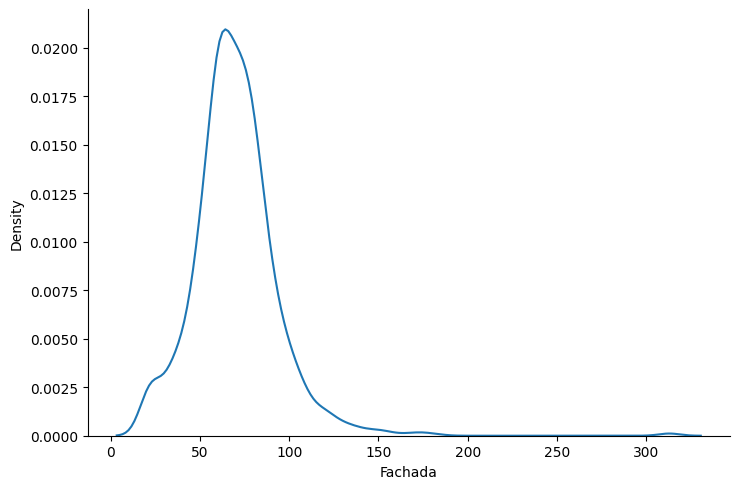

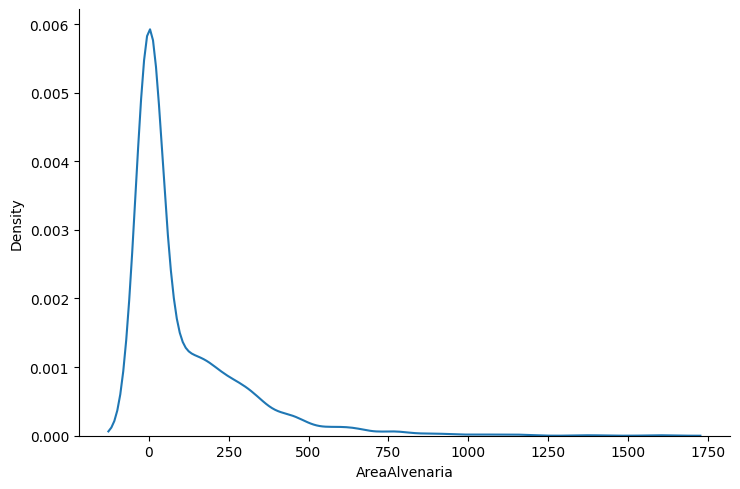

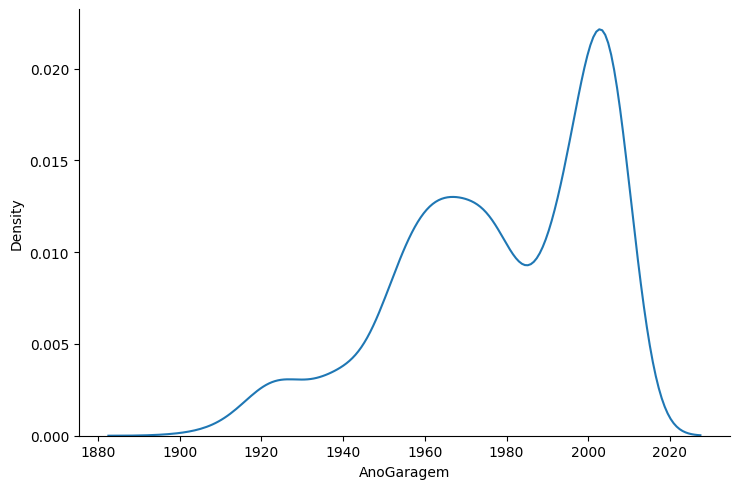

In [12]:
features_numericas = ['Fachada', 'AreaAlvenaria', 'AnoGaragem']

plt.figure(figsize=(6,4))

sns.displot(data = df,
                 x = 'Fachada',
                 kind = 'kde',
                 height = 5,
                 aspect = 1.5)

sns.displot(data = df,
                 x = 'AreaAlvenaria',
                 kind = 'kde',
                 height = 5,
                 aspect = 1.5)

sns.displot(data = df,
                 x = 'AnoGaragem',
                 kind = 'kde',
                 height = 5,
                 aspect = 1.5)

Como as distribuições dessas variáveis são não simétricas, vamos preencher os dados faltantes dessas features com as respectivas medianas

In [13]:
# preenchendo dados faltantes das features numéricas
# utilizando as respectivas medianas

for numericas in features_numericas:
  df[numericas].fillna(df[numericas].median(), inplace = True)

In [14]:
df[features_vazios].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Fachada             1460 non-null   float64
 1   AreaAlvenaria       1460 non-null   float64
 2   AlturaPorao         1423 non-null   object 
 3   CondicaoPorao       1423 non-null   object 
 4   ParedePorao         1422 non-null   object 
 5   TipoAcabPorao1      1423 non-null   object 
 6   TipoAcabPorao2      1422 non-null   object 
 7   InstalacaoEletrica  1459 non-null   object 
 8   LocalGaragem        1379 non-null   object 
 9   AnoGaragem          1460 non-null   float64
 10  AcabamentoGaragem   1379 non-null   object 
 11  QualidadeGaragem    1379 non-null   object 
 12  CondicaoGaragem     1379 non-null   object 
dtypes: float64(3), object(10)
memory usage: 148.4+ KB


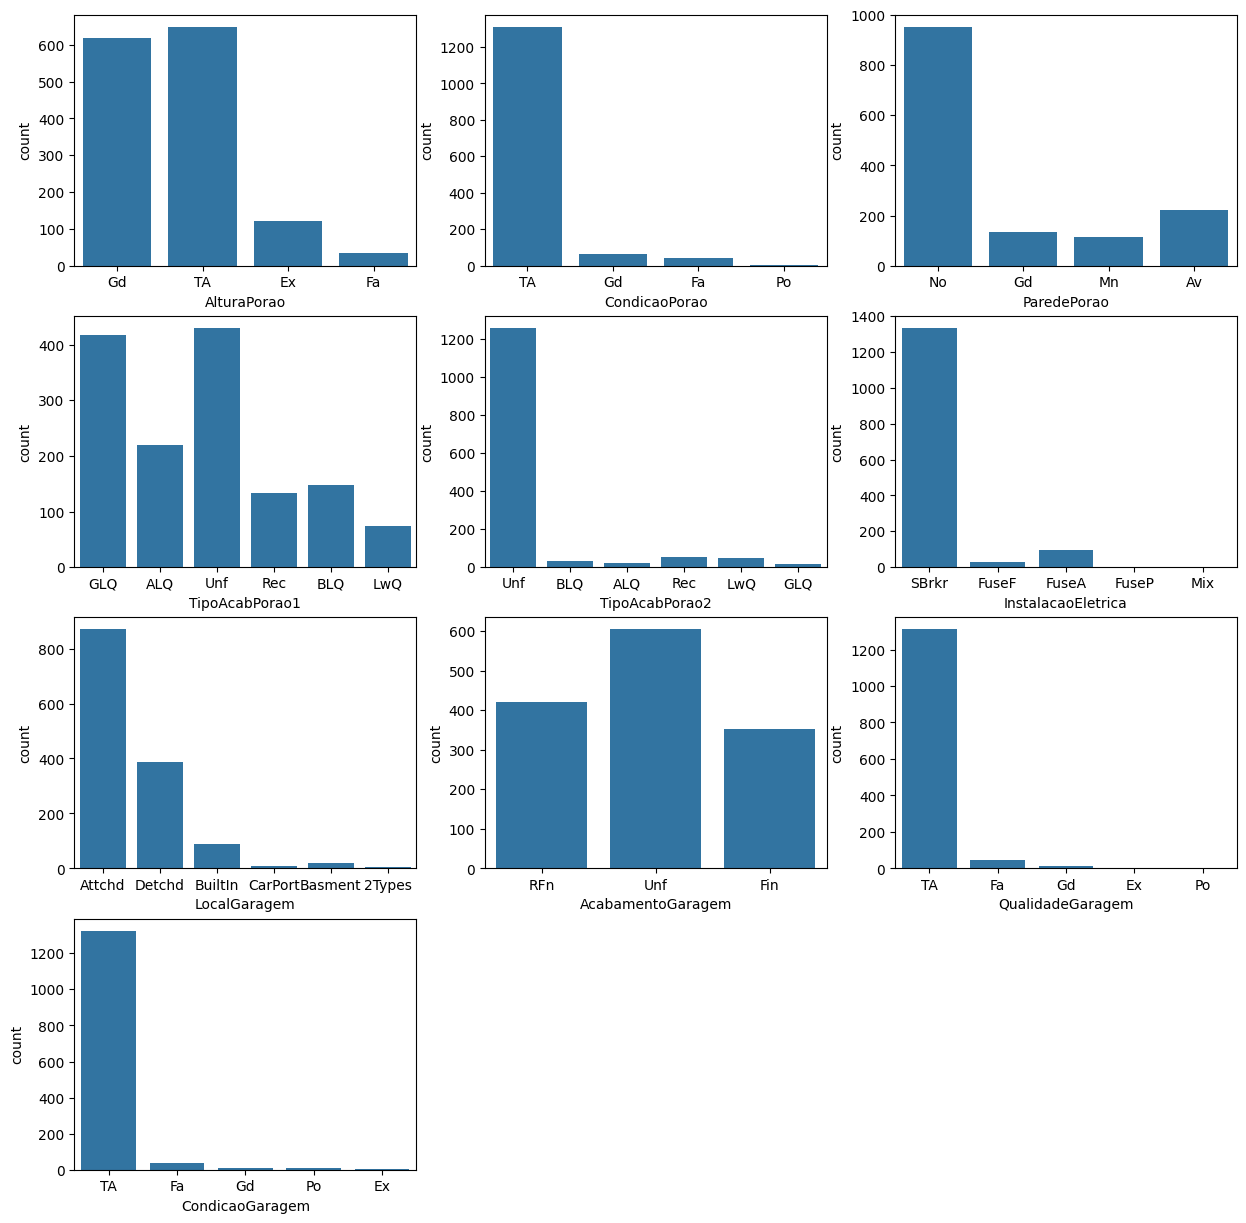

In [15]:
# plotando as features do tipo object com dados vazios
features_object = ['AlturaPorao', 'CondicaoPorao',
                   'ParedePorao', 'TipoAcabPorao1', 'TipoAcabPorao2',
                   'InstalacaoEletrica', 'LocalGaragem', 'AcabamentoGaragem',
                   'QualidadeGaragem', 'CondicaoGaragem']

fig = plt.figure(figsize=(15, 15))

for column in features_object:
  ax = fig.add_subplot(4, 3, features_object.index(column)+1)
  sns.countplot(data = df, x = column)

In [16]:
# preenchendo dados faltantes das features object
# utilizando as respectivas modas

for discr in features_object:
  df[discr].fillna(df[discr].mode()[0], inplace = True)

In [17]:
df[features_vazios].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Fachada             1460 non-null   float64
 1   AreaAlvenaria       1460 non-null   float64
 2   AlturaPorao         1460 non-null   object 
 3   CondicaoPorao       1460 non-null   object 
 4   ParedePorao         1460 non-null   object 
 5   TipoAcabPorao1      1460 non-null   object 
 6   TipoAcabPorao2      1460 non-null   object 
 7   InstalacaoEletrica  1460 non-null   object 
 8   LocalGaragem        1460 non-null   object 
 9   AnoGaragem          1460 non-null   float64
 10  AcabamentoGaragem   1460 non-null   object 
 11  QualidadeGaragem    1460 non-null   object 
 12  CondicaoGaragem     1460 non-null   object 
dtypes: float64(3), object(10)
memory usage: 148.4+ KB


In [18]:
# verificando quantas features possuem dados faltantes
features_vazios = [] # criando para armazenar os nomes das colunas
# loop para identificar colunas com dados vazios
for coluna in df.columns:
  if df[coluna].isnull().sum()> 0:
    features_vazios.append(coluna)

In [19]:
features_vazios

[]

Como observado, agora nosso dataset não possui mais dados faltantes

## Verificando distribuição da variável de interesse

In [20]:
df['PrecoVenda']

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: PrecoVenda, Length: 1460, dtype: int64

<Axes: xlabel='PrecoVenda', ylabel='Count'>

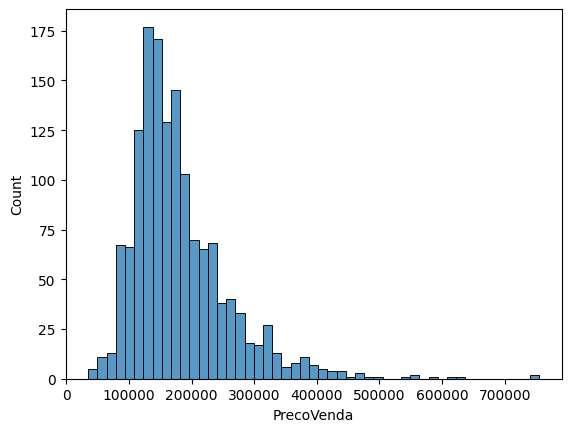

In [21]:
sns.histplot(data = df,
             x = 'PrecoVenda')

<Axes: xlabel='PrecoVenda'>

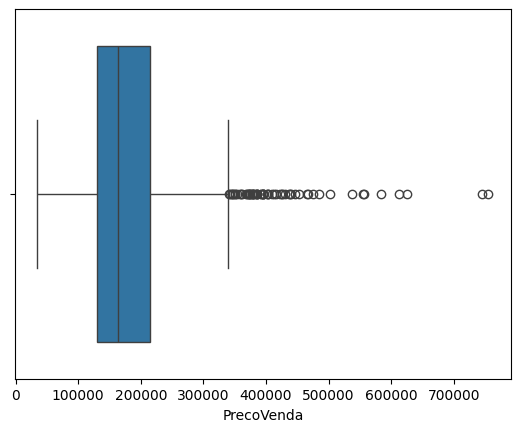

In [22]:
sns.boxplot(data = df,
            x = 'PrecoVenda')

Como pode-se observar, a distribuição de preço dos imóveis é assimétrica a direita 

In [23]:
print('50% dos preços estão entre os valores {} e {}'.format(df['PrecoVenda'].quantile(.25), df['PrecoVenda'].quantile(.75)))

50% dos preços estão entre os valores 129975.0 e 214000.0


## Correlação entre features

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Id                    1460 non-null   int64  
 1   ClasseImovel          1460 non-null   int64  
 2   ClasseZona            1460 non-null   object 
 3   Fachada               1460 non-null   float64
 4   TamanhoLote           1460 non-null   int64  
 5   Rua                   1460 non-null   object 
 6   FormaProp             1460 non-null   object 
 7   PlanoProp             1460 non-null   object 
 8   Servicos              1460 non-null   object 
 9   ConfigLote            1460 non-null   object 
 10  InclinacaoLote        1460 non-null   object 
 11  Bairro                1460 non-null   object 
 12  Estrada1              1460 non-null   object 
 13  Estrada2              1460 non-null   object 
 14  TipoHabitacao         1460 non-null   object 
 15  EstiloHabitacao      

Há features categóricas que representam condição/qualidade de alguma parte do imóvel, porém não estão codificadas.

Vamos codificá-las, de modo crescente, do pior para o melhor, para as incluirmos nas etapas seguintes.

As features são:
'QualidadeCobertura', 'CondicaoExterna', 'AlturaPorao', 'CondicaoPorao', 'ParedePorao', 'TipoAcabPorao1', 'TipoAcabPorao2', 'QualidadeAquecimento', 'QualidadeCozinha', 'QualdiadeLareira', 'QualidadeGaragem', 'CondicaoGaragem', 'QualidadePiscina'

In [25]:
categ_quali = ['QualidadeCobertura', 'CondicaoExterna', 'AlturaPorao', 'CondicaoPorao',
               'ParedePorao', 'TipoAcabPorao1', 'TipoAcabPorao2', 'QualidadeAquecimento',
               'QualidadeCozinha', 'QualidadeGaragem', 'CondicaoGaragem']

df_copia = df.copy() # criando uma cópia de df

#Criando um dicionário
cods = {'No':0,'NA':0,'Mn':1,'Av':3, "Po": 1, 'Fa': 2, "TA": 3, 'Gd': 4, 'Ex': 5,
      'Unf':0,'LwQ':1,'Rec':2,'BLQ':3,'ALQ':4,'GLQ':5}

#Aplicando o difionário para as features categóricas de qualidade
for column in categ_quali:
    df_copia[column]=df_copia[column].map(cods)

In [26]:
df_copia[['QualidadeCobertura', 'CondicaoExterna', 'AlturaPorao', 'CondicaoPorao',
               'ParedePorao', 'TipoAcabPorao1', 'TipoAcabPorao2', 'QualidadeAquecimento',
               'QualidadeCozinha', 'QualidadeGaragem', 'CondicaoGaragem']]

,QualidadeCobertura,CondicaoExterna,AlturaPorao,CondicaoPorao,ParedePorao,TipoAcabPorao1,TipoAcabPorao2,QualidadeAquecimento,QualidadeCozinha,QualidadeGaragem,CondicaoGaragem
0,4,3,4,3,0,5,0,5,4,3,3
1,3,3,4,3,4,4,0,5,3,3,3
2,4,3,4,3,1,5,0,5,4,3,3
3,3,3,3,4,0,4,0,4,4,3,3
4,4,3,4,3,3,5,0,5,4,3,3
...,...,...,...,...,...,...,...,...,...,...,...
1455,3,3,4,3,0,0,0,5,3,3,3
1456,3,3,4,3,0,4,2,3,3,3,3
1457,5,4,3,4,0,5,0,5,4,3,3
1458,3,3,3,3,1,5,2,4,4,3,3


In [27]:
df_copia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Id                    1460 non-null   int64  
 1   ClasseImovel          1460 non-null   int64  
 2   ClasseZona            1460 non-null   object 
 3   Fachada               1460 non-null   float64
 4   TamanhoLote           1460 non-null   int64  
 5   Rua                   1460 non-null   object 
 6   FormaProp             1460 non-null   object 
 7   PlanoProp             1460 non-null   object 
 8   Servicos              1460 non-null   object 
 9   ConfigLote            1460 non-null   object 
 10  InclinacaoLote        1460 non-null   object 
 11  Bairro                1460 non-null   object 
 12  Estrada1              1460 non-null   object 
 13  Estrada2              1460 non-null   object 
 14  TipoHabitacao         1460 non-null   object 
 15  EstiloHabitacao      

In [28]:
# identificando dados do tipo int64 que são discretos
dropar = ['Id','ClasseImovel',]

# criando outro df sem as features com dtype int64, porém qua não faziam sentido
df_cont = df_copia.select_dtypes(exclude='object').drop(dropar, axis = 1)
df_cont.head()

,Fachada,TamanhoLote,Qualidade,Condicao,AnoConstrucao,AnoReforma,AreaAlvenaria,QualidadeCobertura,CondicaoExterna,AlturaPorao,...,AreaDeck,AreaVarandaAberta,AreaVarandaFechada,AreaVaranda3Estacoes,AreaAlpendre,AreaPiscina,ValorOutros,MesVenda,AnoVenda,PrecoVenda
0,65.0,8450,7,5,2003,2003,196.0,4,3,4,...,0,61,0,0,0,0,0,2,2008,208500
1,80.0,9600,6,8,1976,1976,0.0,3,3,4,...,298,0,0,0,0,0,0,5,2007,181500
2,68.0,11250,7,5,2001,2002,162.0,4,3,4,...,0,42,0,0,0,0,0,9,2008,223500
3,60.0,9550,7,5,1915,1970,0.0,3,3,3,...,0,35,272,0,0,0,0,2,2006,140000
4,84.0,14260,8,5,2000,2000,350.0,4,3,4,...,192,84,0,0,0,0,0,12,2008,250000


É importante salientar que as features como Qualidade, Condição.. representam uma característica, porém estão categorizadas de forma crescente, ou seja, 1 é a pior avaliação e 10 a melhor. Assim, faz sentido utiliza-las na matriz de correlação.

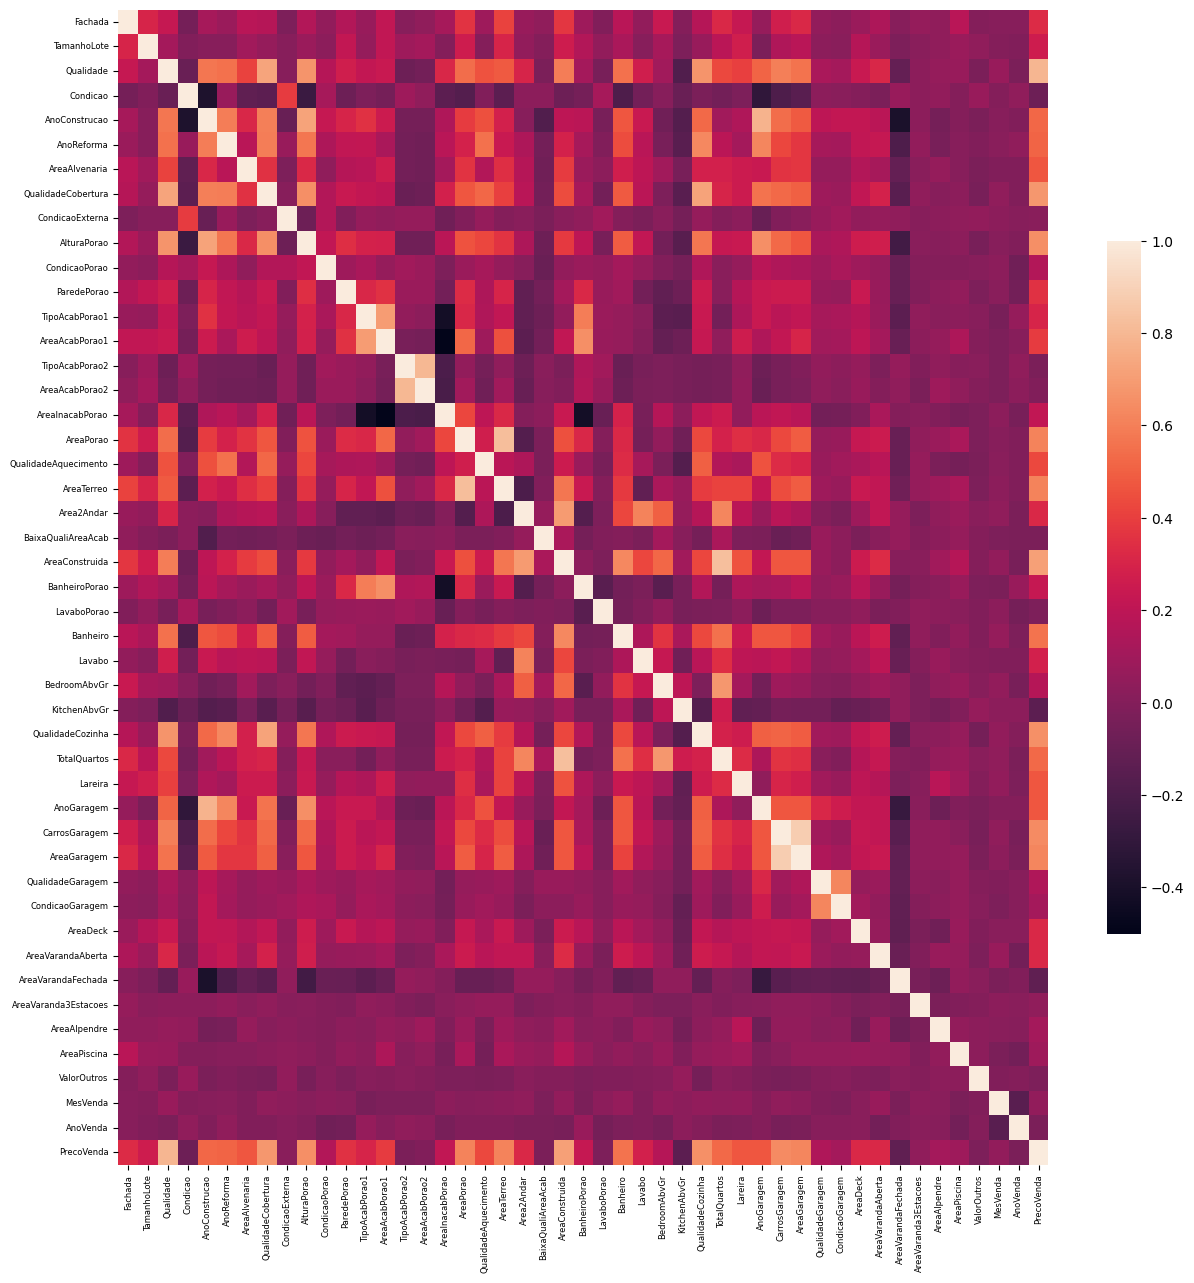

In [29]:
plt.figure(figsize = (15, 15))
ax = sns.heatmap(df_cont.corr().round(2),
                 #annot = True,
                 #annot_kws={"size":7},
                 cbar_kws={'shrink': 0.6})
ax.tick_params(labelsize = 6)

In [30]:
# Correlação das features com nossa variável de interesse
df_cont.corrwith(df_cont['PrecoVenda']).sort_values(ascending=False).head(100)

PrecoVenda              1.000000
Qualidade               0.790982
AreaConstruida          0.708624
QualidadeCobertura      0.682639
QualidadeCozinha        0.659600
AlturaPorao             0.650138
CarrosGaragem           0.640409
AreaGaragem             0.623431
AreaPorao               0.613581
AreaTerreo              0.605852
Banheiro                0.560664
TotalQuartos            0.533723
AnoConstrucao           0.522897
AnoReforma              0.507101
AreaAlvenaria           0.472614
Lareira                 0.466929
AnoGaragem              0.466754
QualidadeAquecimento    0.427649
AreaAcabPorao1          0.386420
ParedePorao             0.354435
Fachada                 0.334771
AreaDeck                0.324413
Area2Andar              0.319334
AreaVarandaAberta       0.315856
TipoAcabPorao1          0.298771
Lavabo                  0.284108
TamanhoLote             0.263843
BanheiroPorao           0.227122
AreaInacabPorao         0.214479
BedroomAbvGr            0.168213
CondicaoPo

Antes de plotarmos os gráficos para as variáveis contínuas, vamos verificar se existe multicolinearidade entre as variáveis independentes.

Para isso, utilizaremos a função VIF, do statsmodel

Para otimizar o processo, vamos utilizar somente as variáveis que apresentaram correlação maior que 0.6, mostrados no heatmap de correlação
A função que utiliza a VIF foi retirada desse artigo:
https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/

In [31]:
features_alta_correlacao = ['Qualidade', 'AreaConstruida', 'QualidadeCobertura',
                            'QualidadeCozinha', 'AlturaPorao','CarrosGaragem',
                            'AreaGaragem', 'AreaPorao', 'AreaTerreo',
                            'Banheiro', 'TotalQuartos', 'AnoConstrucao', 'AnoReforma']

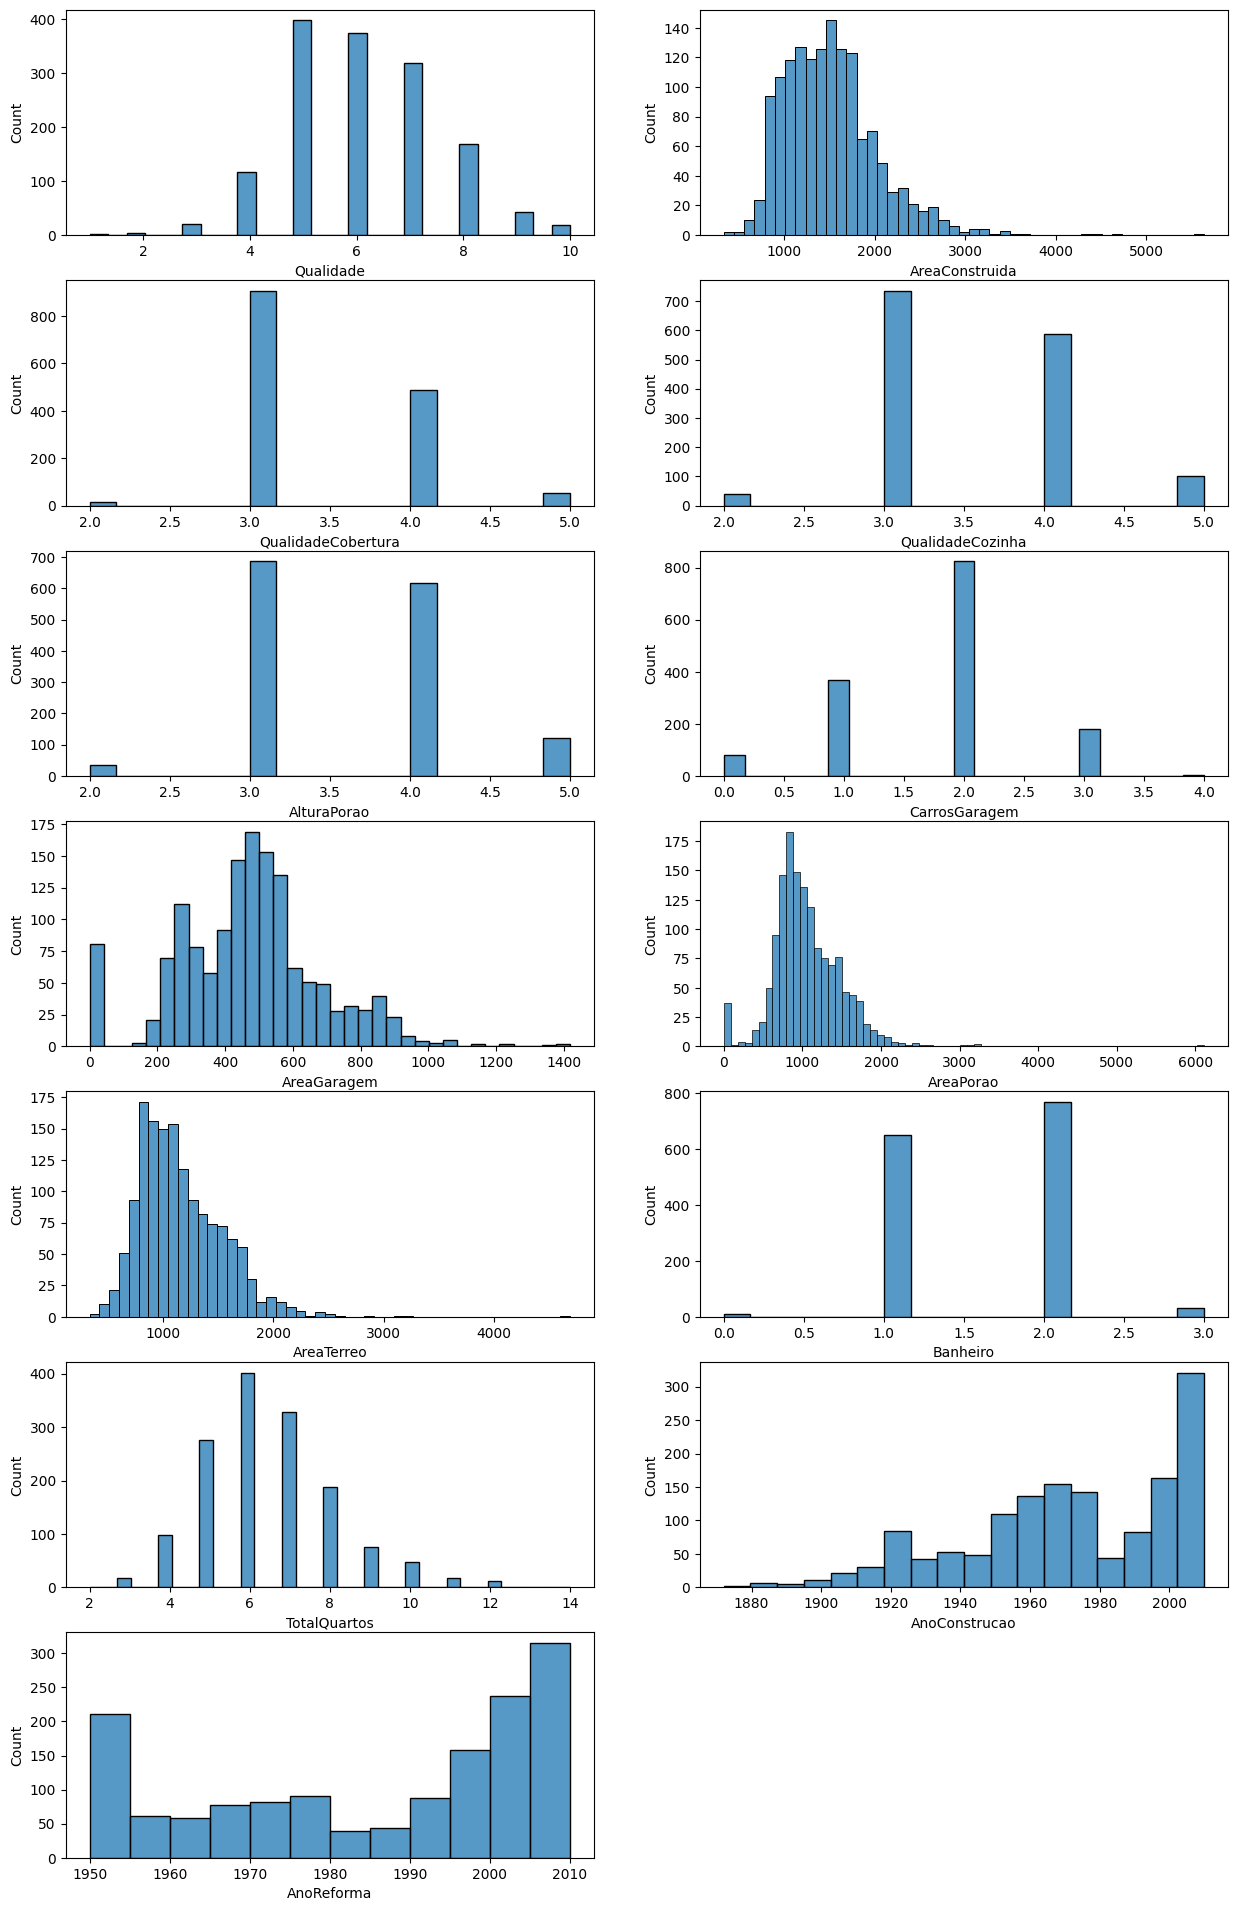

In [32]:
# Distribuição das features importantes

# plotando as features do tipo object com dados vazios
fig = plt.figure(figsize=(15, 24))

for column in features_alta_correlacao:
  ax = fig.add_subplot(7, 2, features_alta_correlacao.index(column)+1)
  sns.histplot(df_copia[column])

In [33]:
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [34]:
calc_vif(df_copia[features_alta_correlacao])

,variables,VIF
0,Qualidade,69.320612
1,AreaConstruida,46.063135
2,QualidadeCobertura,103.623810
3,QualidadeCozinha,70.513174
4,AlturaPorao,71.091480
5,CarrosGaragem,34.572222
6,AreaGaragem,29.327628
7,AreaPorao,24.946684
8,AreaTerreo,37.097048
9,Banheiro,18.708490


<Axes: xlabel='AnoConstrucao', ylabel='AnoReforma'>

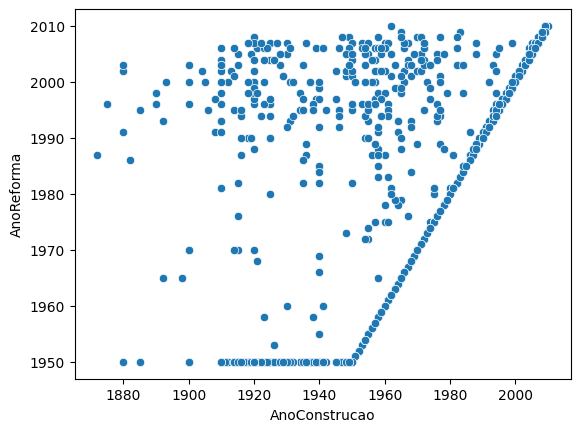

In [35]:
sns.scatterplot(x = df_copia['AnoConstrucao'],
                y = df_copia['AnoReforma'])

A correlação entre AnoConstrução e AnoReforma é muito alta. Porém isso se deve ao fato de que quando não houve reforma, aplica-se o mesmo ano de Contrução. Assim, vamos criar uma nova feature Idade_na_reforma = AnoContrucao - AnoReforma

A multicolinearidade é muito alta entre as features com maiores correlações. Porém, ao invés de elimina-las, vamos criar novas features.



In [36]:
df_copia_novas_features = df_copia.copy()

In [37]:
df_copia_novas_features['Idade_na_reforma'] = df_copia['AnoReforma'] - df_copia['AnoConstrucao']
df_copia_novas_features['AreaConstruida_log'] = (df_copia['AreaConstruida']+1).apply(np.log)
df_copia_novas_features['AreaGaragem_log'] = (df_copia['AreaGaragem']+1).apply(np.log)
df_copia_novas_features['AreaPorao_log'] = (df_copia['AreaPorao']+1).apply(np.log)
df_copia_novas_features['AreaTerreo_log'] = (df_copia['AreaTerreo']+1).apply(np.log)
df_copia_novas_features['Total_Q_B'] = df_copia['TotalQuartos'] + df_copia['Banheiro']
df_copia_novas_features['Qualidade_Total'] = df_copia['QualidadeCobertura'] + df_copia['QualidadeCozinha']

In [38]:
df_copia_novas_features[['Idade_na_reforma','AreaConstruida_log','AreaGaragem_log',
          'AreaPorao_log', 'AreaTerreo_log', 'Total_Q_B',
          'Qualidade_Total']]

,Idade_na_reforma,AreaConstruida_log,AreaGaragem_log,AreaPorao_log,AreaTerreo_log,Total_Q_B,Qualidade_Total
0,0,7.444833,6.308098,6.753438,6.753438,10,8
1,0,7.141245,6.133398,7.141245,7.141245,8,6
2,1,7.488294,6.411818,6.825460,6.825460,8,8
3,55,7.448916,6.466145,6.629363,6.869014,8,7
4,0,7.695758,6.729824,7.044033,7.044033,11,8
...,...,...,...,...,...,...,...
1455,1,7.407318,6.133398,6.860664,6.860664,9,6
1456,10,7.637234,6.216606,7.341484,7.637234,9,6
1457,65,7.758333,5.533389,7.050123,7.080868,11,9
1458,46,6.983790,5.484797,6.983790,6.983790,6,7


In [39]:
df_copia_novas_features[['Idade_na_reforma','AreaConstruida_log','AreaGaragem_log',
          'AreaPorao_log', 'AreaTerreo_log', 'Total_Q_B','Qualidade_Total']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Idade_na_reforma    1460 non-null   int64  
 1   AreaConstruida_log  1460 non-null   float64
 2   AreaGaragem_log     1460 non-null   float64
 3   AreaPorao_log       1460 non-null   float64
 4   AreaTerreo_log      1460 non-null   float64
 5   Total_Q_B           1460 non-null   int64  
 6   Qualidade_Total     1460 non-null   int64  
dtypes: float64(4), int64(3)
memory usage: 80.0 KB


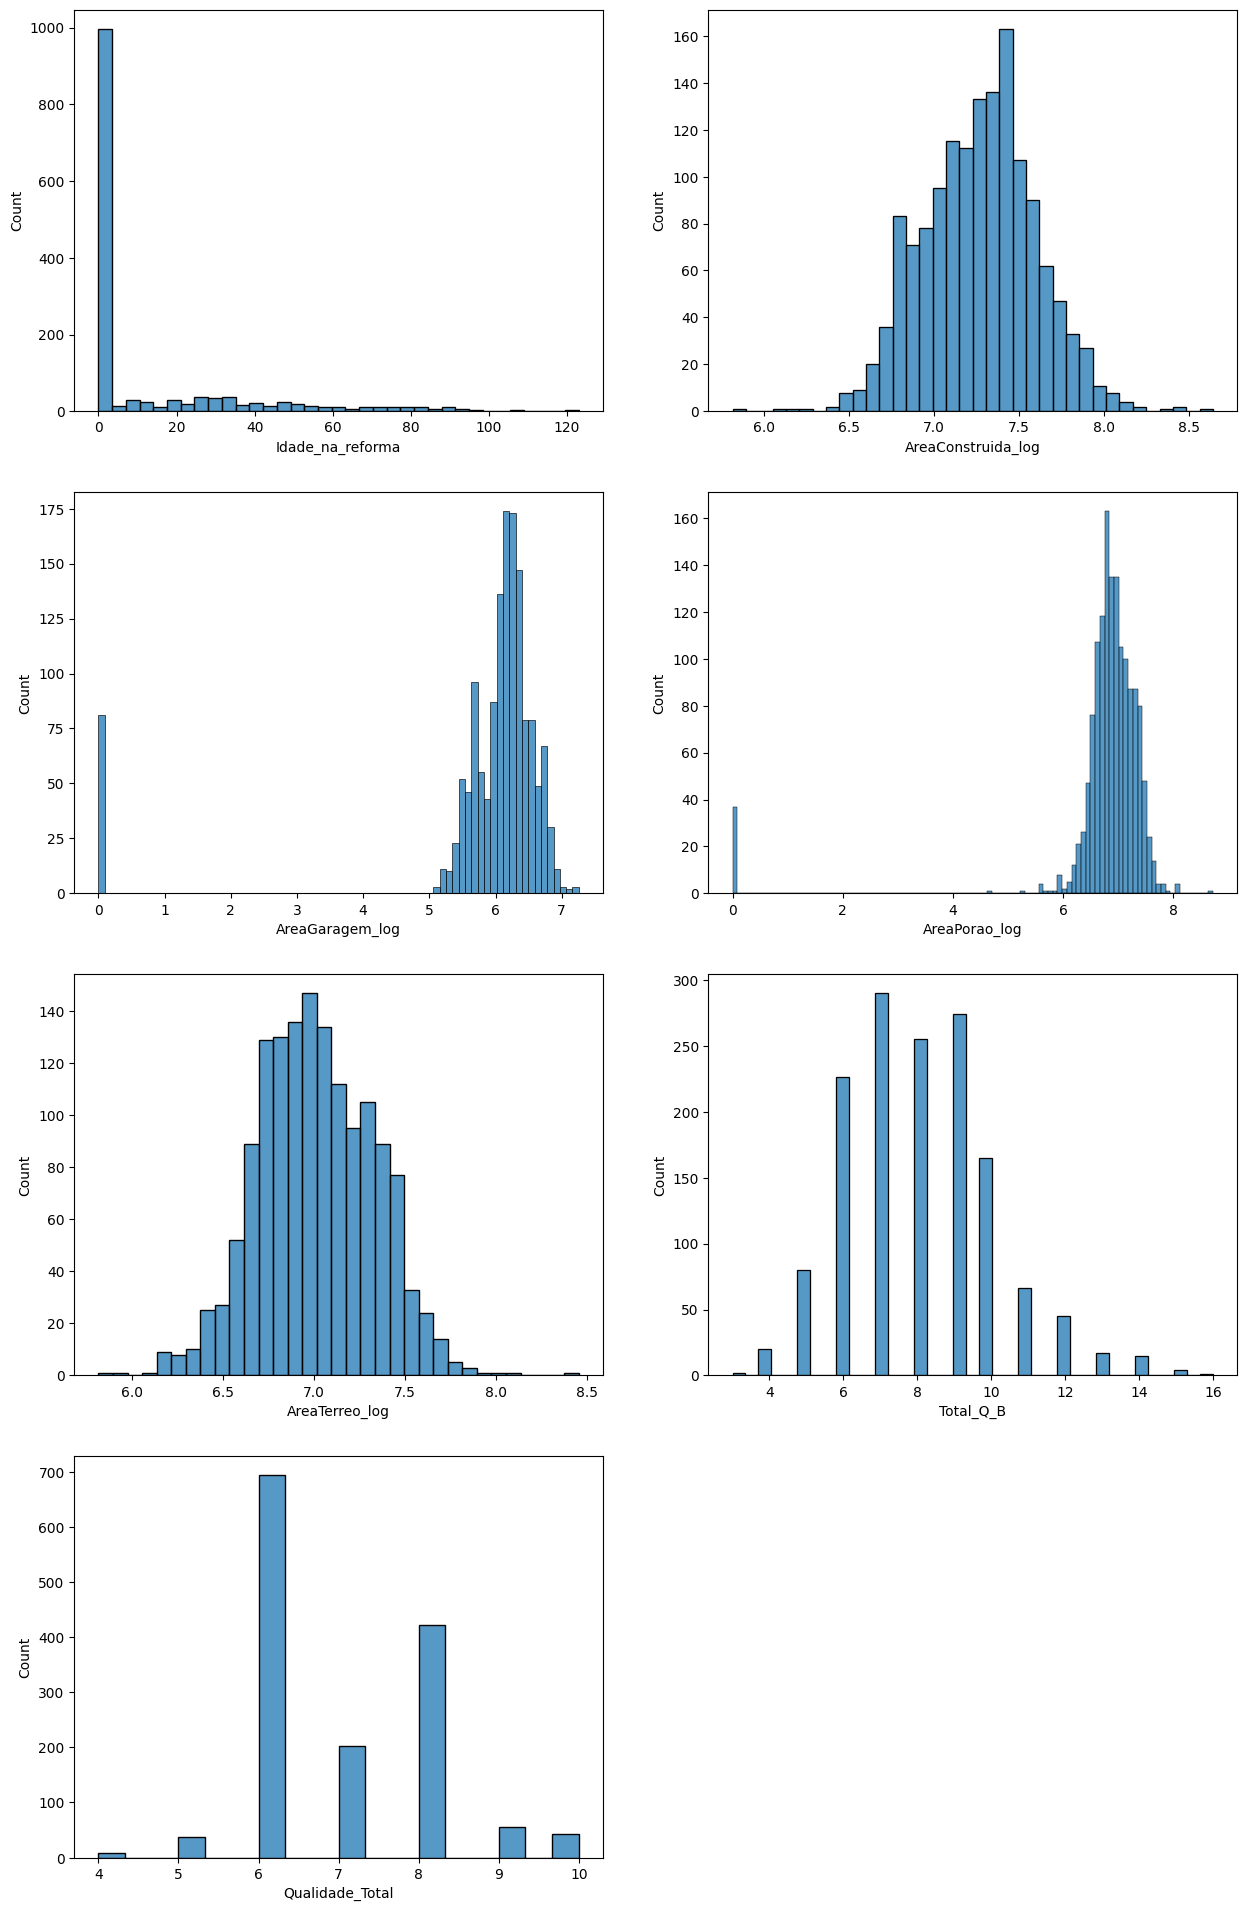

In [40]:
# Distribuição das features importantes
novas_features = ['Idade_na_reforma','AreaConstruida_log','AreaGaragem_log',
                  'AreaPorao_log', 'AreaTerreo_log', 'Total_Q_B', 'Qualidade_Total']
# plotando as features do tipo object com dados vazios
fig = plt.figure(figsize=(15, 24))

for column in novas_features:
  ax = fig.add_subplot(4, 2, novas_features.index(column)+1)
  sns.histplot(df_copia_novas_features[column])

<Axes: xlabel='Qualidade_Total', ylabel='PrecoVenda'>

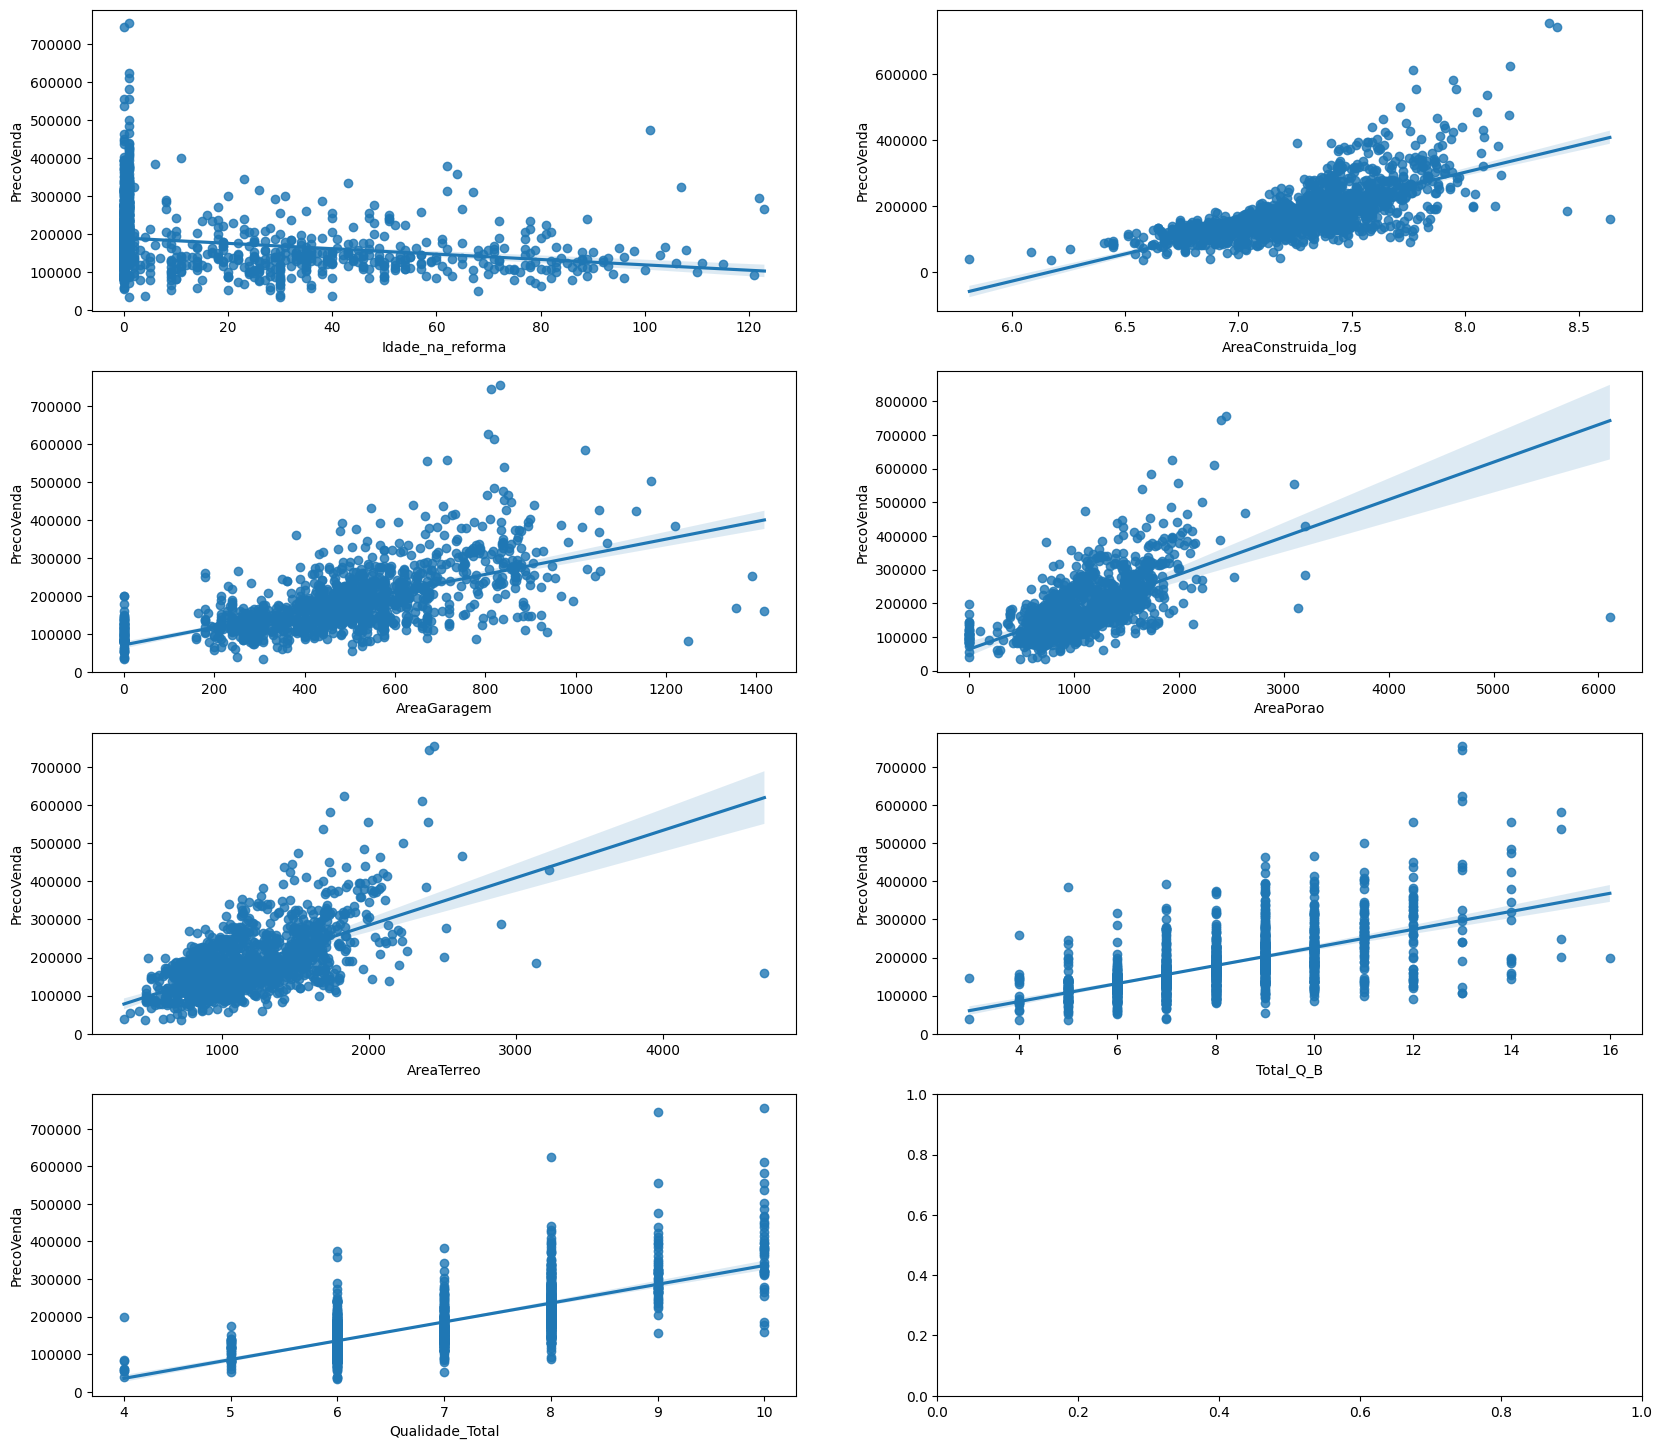

In [41]:
novas_features = ['Idade_na_reforma','AreaConstruida_log','AreaGaragem_log',
                  'AreaPorao_log', 'AreaTerreo_log', 'Total_Q_B', 'Qualidade_Total']

#plotting most correlated features based on SalePrice
fig, ax = plt.subplots(4,2,figsize=(20,18))

sns.regplot(x=df_copia_novas_features['Idade_na_reforma'],y=df['PrecoVenda'],ax=ax[0,0])
sns.regplot(x=df_copia_novas_features['AreaConstruida_log'],y=df['PrecoVenda'],ax=ax[0,1])
sns.regplot(x=df_copia_novas_features['AreaGaragem'],y=df['PrecoVenda'],ax=ax[1,0])
sns.regplot(x=df_copia_novas_features['AreaPorao'],y=df['PrecoVenda'],ax=ax[1,1])
sns.regplot(x=df_copia_novas_features['AreaTerreo'],y=df['PrecoVenda'],ax=ax[2,0])
sns.regplot(x=df_copia_novas_features['Total_Q_B'],y=df['PrecoVenda'],ax=ax[2,1])
sns.regplot(x=df_copia_novas_features['Qualidade_Total'],y=df['PrecoVenda'],ax=ax[3,0])

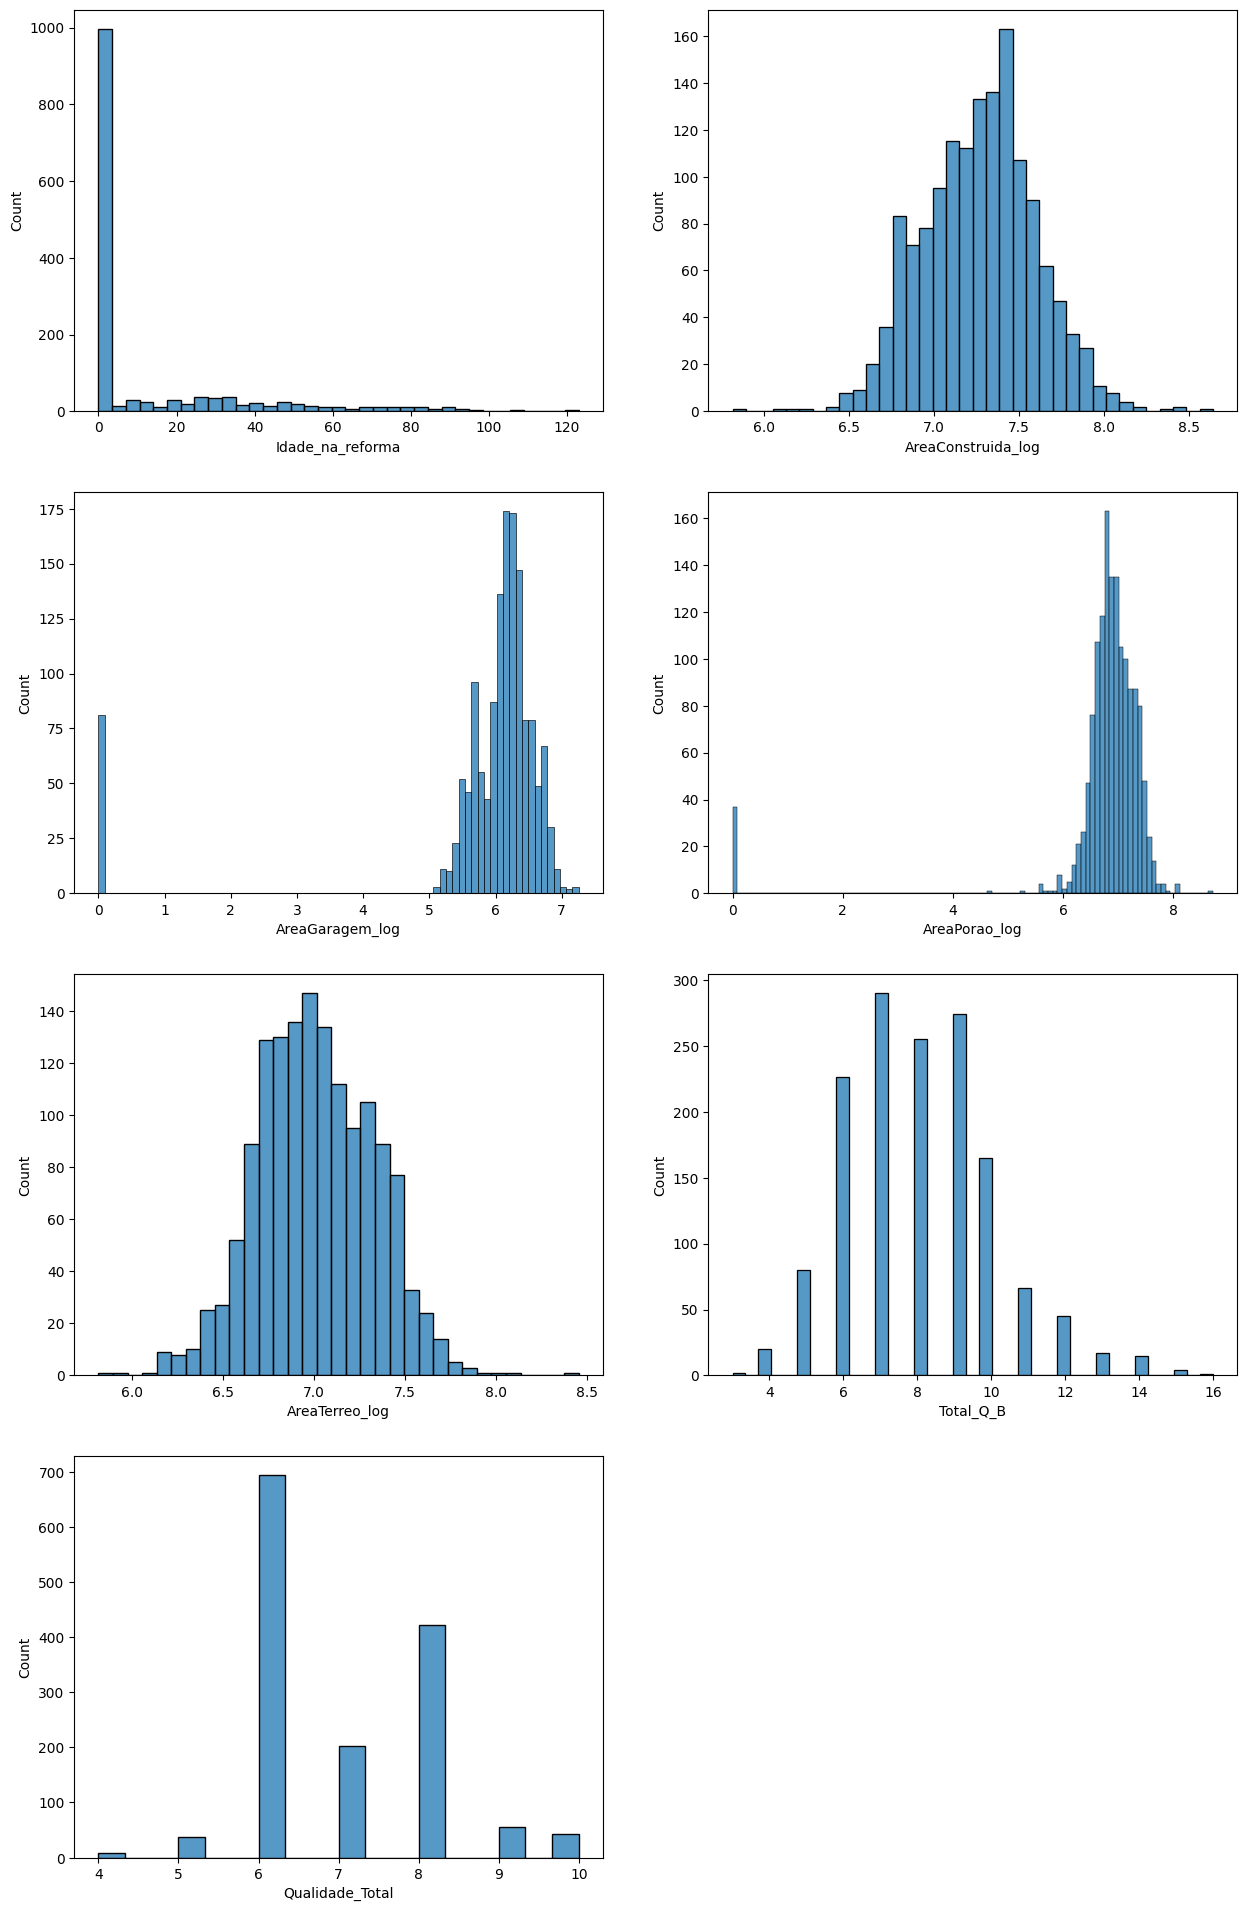

In [42]:
novas_features = ['Idade_na_reforma','AreaConstruida_log','AreaGaragem_log',
                  'AreaPorao_log', 'AreaTerreo_log', 'Total_Q_B', 'Qualidade_Total']

# plotando as novas features 
fig = plt.figure(figsize=(15, 24))

for column in novas_features:
  ax = fig.add_subplot(4, 2, novas_features.index(column)+1)
  sns.histplot(df_copia_novas_features[column])

A idade do imóvel na reforma parece não ter tanto sentido.

Faremos o mesmo plot, porém, mudando para o ano da Construção

<Axes: xlabel='AnoConstrucao', ylabel='PrecoVenda'>

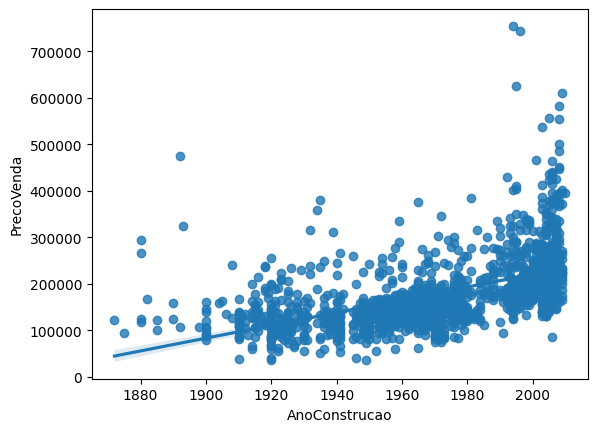

In [43]:
sns.regplot(x=df_copia_novas_features['AnoConstrucao'],y=df['PrecoVenda'])

In [44]:
features_consideradas = ['AnoConstrucao','AreaConstruida_log','AreaGaragem_log',
                          'AreaPorao_log', 'AreaTerreo_log', 'Total_Q_B', 'Qualidade_Total']

In [45]:
calc_vif(df_copia_novas_features[features_consideradas])

,variables,VIF
0,AnoConstrucao,1278.334109
1,AreaConstruida_log,1826.564028
2,AreaGaragem_log,19.785830
3,AreaPorao_log,40.687911
4,AreaTerreo_log,757.339027
5,Total_Q_B,59.690646
6,Qualidade_Total,53.108364


A Colinearidade está alta. Vamos tentar mudar alguns parâmetros.

criaremos a nova feature:
 - Quartos_Area = Total_Q_B/AreaConstruida

In [46]:
# criando a nova feature
df_copia_novas_features['Quartos_por_Area'] = df_copia_novas_features['Total_Q_B']*df_copia_novas_features['AreaConstruida']

<Axes: xlabel='Quartos_por_Area', ylabel='PrecoVenda'>

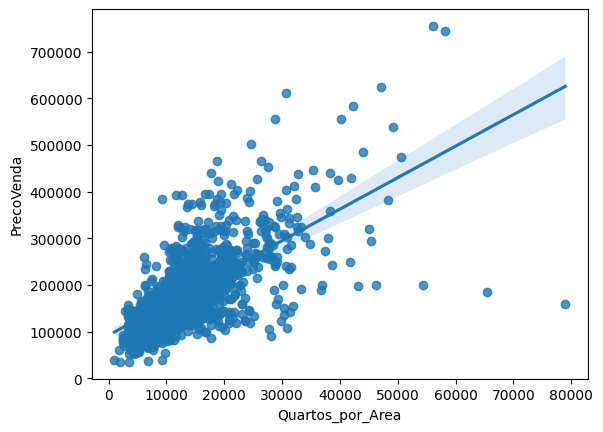

In [47]:
#plotando a nova feature por preço
sns.regplot(x=df_copia_novas_features['Quartos_por_Area'],y=df['PrecoVenda'])

Parece ter um comportamento interessante.
Agoram vamos ver como fica a VIF, considerando essa nova feature e desconsiderando as outras

In [48]:
features_consideradas = ['AnoConstrucao','AreaGaragem_log', 'AreaPorao_log',
                         'AreaTerreo_log', 'Qualidade_Total', 'Quartos_por_Area']

In [49]:
calc_vif(df_copia_novas_features[features_consideradas])

,variables,VIF
0,AnoConstrucao,645.264000
1,AreaGaragem_log,19.703476
2,AreaPorao_log,40.307428
3,AreaTerreo_log,690.704300
4,Qualidade_Total,54.868766
5,Quartos_por_Area,5.484788


In [50]:
# calculando VIF novamente, porém sem AreaTerreo
calc_vif(df_copia_novas_features[features_consideradas].drop(['AreaTerreo_log'], axis=1))

,variables,VIF
0,AnoConstrucao,69.975024
1,AreaGaragem_log,19.537179
2,AreaPorao_log,38.870372
3,Qualidade_Total,54.860429
4,Quartos_por_Area,4.651955


Como AnoContrucao ainda está alto, vamos voltar com a Idade_na_reforma

In [51]:
features_consideradas = ['Idade_na_reforma','AreaGaragem_log', 'AreaPorao_log',
                         'AreaTerreo_log', 'Qualidade_Total', 'Quartos_por_Area']

In [52]:
# calculando VIF novamente
calc_vif(df_copia_novas_features[features_consideradas])

,variables,VIF
0,Idade_na_reforma,1.398251
1,AreaGaragem_log,20.506781
2,AreaPorao_log,40.309968
3,AreaTerreo_log,79.837438
4,Qualidade_Total,53.665111
5,Quartos_por_Area,4.526788


In [53]:
# calculando VIF novamente, agora sem AreaTerreo
calc_vif(df_copia_novas_features[features_consideradas].drop(['AreaTerreo_log'], axis=1))

,variables,VIF
0,Idade_na_reforma,1.311826
1,AreaGaragem_log,18.757246
2,AreaPorao_log,27.921233
3,Qualidade_Total,37.150669
4,Quartos_por_Area,4.514823


In [54]:
# calculando VIF novamente, agora sem AreaPorao
calc_vif(df_copia_novas_features[features_consideradas].drop(['AreaTerreo_log','AreaPorao_log'], axis=1))

,variables,VIF
0,Idade_na_reforma,1.268930
1,AreaGaragem_log,17.229467
2,Qualidade_Total,20.928280
3,Quartos_por_Area,4.488388


In [55]:
# calculando VIF novamente, agora sem AreaPorao
calc_vif(df_copia_novas_features[features_consideradas].drop(['AreaTerreo_log','AreaPorao_log','Qualidade_Total'], axis=1))

,variables,VIF
0,Idade_na_reforma,1.232908
1,AreaGaragem_log,3.825300
2,Quartos_por_Area,3.824419


Agora, vamos tentar com AnoContrucao novamente. Porém, há uma informação que pode ser útil no dataset (ano de venda)

Criaremos uma feature (ano_imovel)

In [56]:
df_copia_novas_features['ano_imovel'] = df_copia_novas_features['AnoVenda'] - df_copia_novas_features['AnoConstrucao']

In [57]:
features_consideradas = ['ano_imovel', 'Quartos_por_Area','AreaGaragem_log']

# calculando VIF
calc_vif(df_copia_novas_features[features_consideradas])

,variables,VIF
0,ano_imovel,1.932287
1,Quartos_por_Area,3.763115
2,AreaGaragem_log,4.643312


<Axes: xlabel='ano_imovel', ylabel='PrecoVenda'>

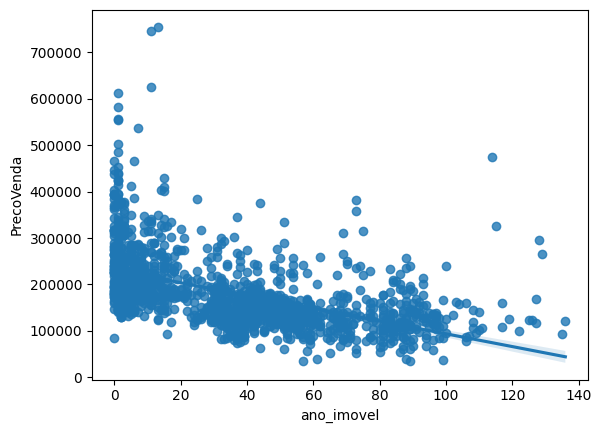

In [58]:
#plotando a nova feature por preço
sns.regplot(x=df_copia_novas_features['ano_imovel'],y=df['PrecoVenda'])

Agora, uma nova feature,
Qualidade*Condicao

In [59]:
df_copia_novas_features['qualidade*condicao'] = (df_copia_novas_features['Qualidade']*df_copia_novas_features['Condicao'])**2

In [60]:
features_consideradas = ['ano_imovel', 'Quartos_por_Area', 'AreaGaragem_log','qualidade*condicao']

# calculando VIF
calc_vif(df_copia_novas_features[features_consideradas])

,variables,VIF
0,ano_imovel,1.969405
1,Quartos_por_Area,4.517730
2,AreaGaragem_log,5.837165
3,qualidade*condicao,5.105749


Adicionando 'CarrosGaragem_vs_QualidadeGaragem_vs_CondicaoGaragem' na VIF

In [61]:
df_copia_novas_features['garagem_total'] = df_copia_novas_features['CondicaoGaragem']*df_copia_novas_features['QualidadeGaragem']*df_copia_novas_features['CarrosGaragem']

In [62]:
features_consideradas = ['ano_imovel', 'Quartos_por_Area', 'AreaGaragem_log',
                         'qualidade*condicao', 'garagem_total']

# calculando VIF
calc_vif(df_copia_novas_features[features_consideradas])

,variables,VIF
0,ano_imovel,2.842570
1,Quartos_por_Area,5.056963
2,AreaGaragem_log,20.535550
3,qualidade*condicao,5.280010
4,garagem_total,19.112695


In [63]:
features_consideradas = ['ano_imovel', 'Quartos_por_Area',
                         'qualidade*condicao', 'garagem_total']

# calculando VIF
calc_vif(df_copia_novas_features[features_consideradas])

,variables,VIF
0,ano_imovel,1.777455
1,Quartos_por_Area,5.041135
2,qualidade*condicao,5.243281
3,garagem_total,5.432723


Criando Fachada ao quadrado

In [64]:
df_copia_novas_features['fachada_quadrado'] = df_copia_novas_features['Fachada']**2

In [65]:
features_consideradas = ['ano_imovel', 'Quartos_por_Area', 'qualidade*condicao',
                         'garagem_total','fachada_quadrado']

# calculando VIF
calc_vif(df_copia_novas_features[features_consideradas])

,variables,VIF
0,ano_imovel,1.808441
1,Quartos_por_Area,5.522259
2,qualidade*condicao,5.243310
3,garagem_total,5.655273
4,fachada_quadrado,2.557034


Criando Feature para o Porão

In [66]:
df_copia_novas_features['porao_geral'] = (df_copia_novas_features['AlturaPorao']+df_copia_novas_features['ParedePorao'])*df_copia_novas_features['CondicaoPorao']

In [67]:
features_consideradas = ['ano_imovel', 'Quartos_por_Area', 'qualidade*condicao',
                         'garagem_total','fachada_quadrado', 'porao_geral']

# calculando VIF
calc_vif(df_copia_novas_features[features_consideradas])

,variables,VIF
0,ano_imovel,1.815676
1,Quartos_por_Area,5.524810
2,qualidade*condicao,5.474492
3,garagem_total,8.125569
4,fachada_quadrado,2.632644
5,porao_geral,6.348563


In [68]:
# Correlação das features com nossas novas features
df_copia_novas_features[features_consideradas].corrwith(df_copia['PrecoVenda']).sort_values(ascending=False)

Quartos_por_Area      0.672697
garagem_total         0.648276
qualidade*condicao    0.533767
porao_geral           0.528612
fachada_quadrado      0.247068
ano_imovel           -0.523350
dtype: float64

<Axes: xlabel='ano_imovel', ylabel='PrecoVenda'>

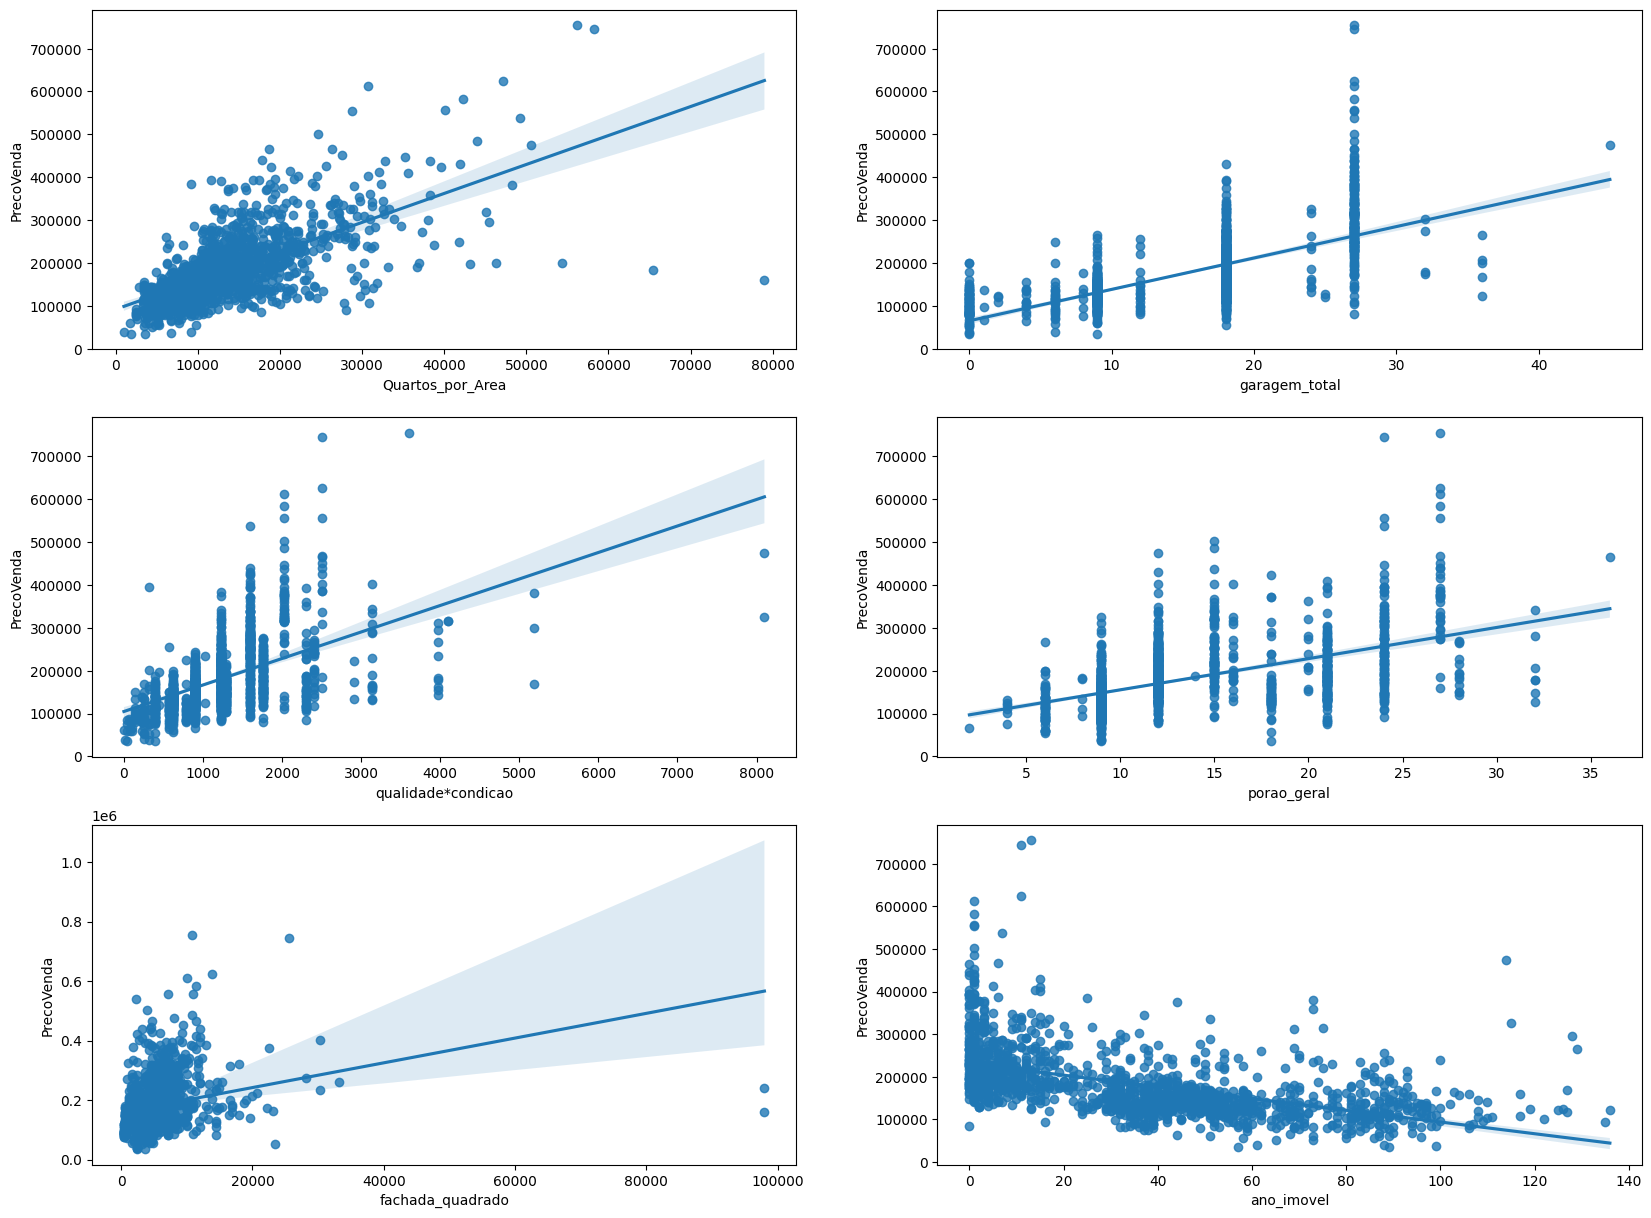

In [69]:
# Plotando a correlação das features novas com o preço de venda
fig, ax = plt.subplots(3,2,figsize=(20,15))

sns.regplot(x=df_copia_novas_features['Quartos_por_Area'],y=df['PrecoVenda'],ax=ax[0,0])
sns.regplot(x=df_copia_novas_features['garagem_total'],y=df['PrecoVenda'],ax=ax[0,1])
sns.regplot(x=df_copia_novas_features['qualidade*condicao'],y=df['PrecoVenda'],ax=ax[1,0])
sns.regplot(x=df_copia_novas_features['porao_geral'],y=df['PrecoVenda'],ax=ax[1,1])
sns.regplot(x=df_copia_novas_features['fachada_quadrado'],y=df['PrecoVenda'],ax=ax[2,0])
sns.regplot(x=df_copia_novas_features['ano_imovel'],y=df['PrecoVenda'],ax=ax[2,1])

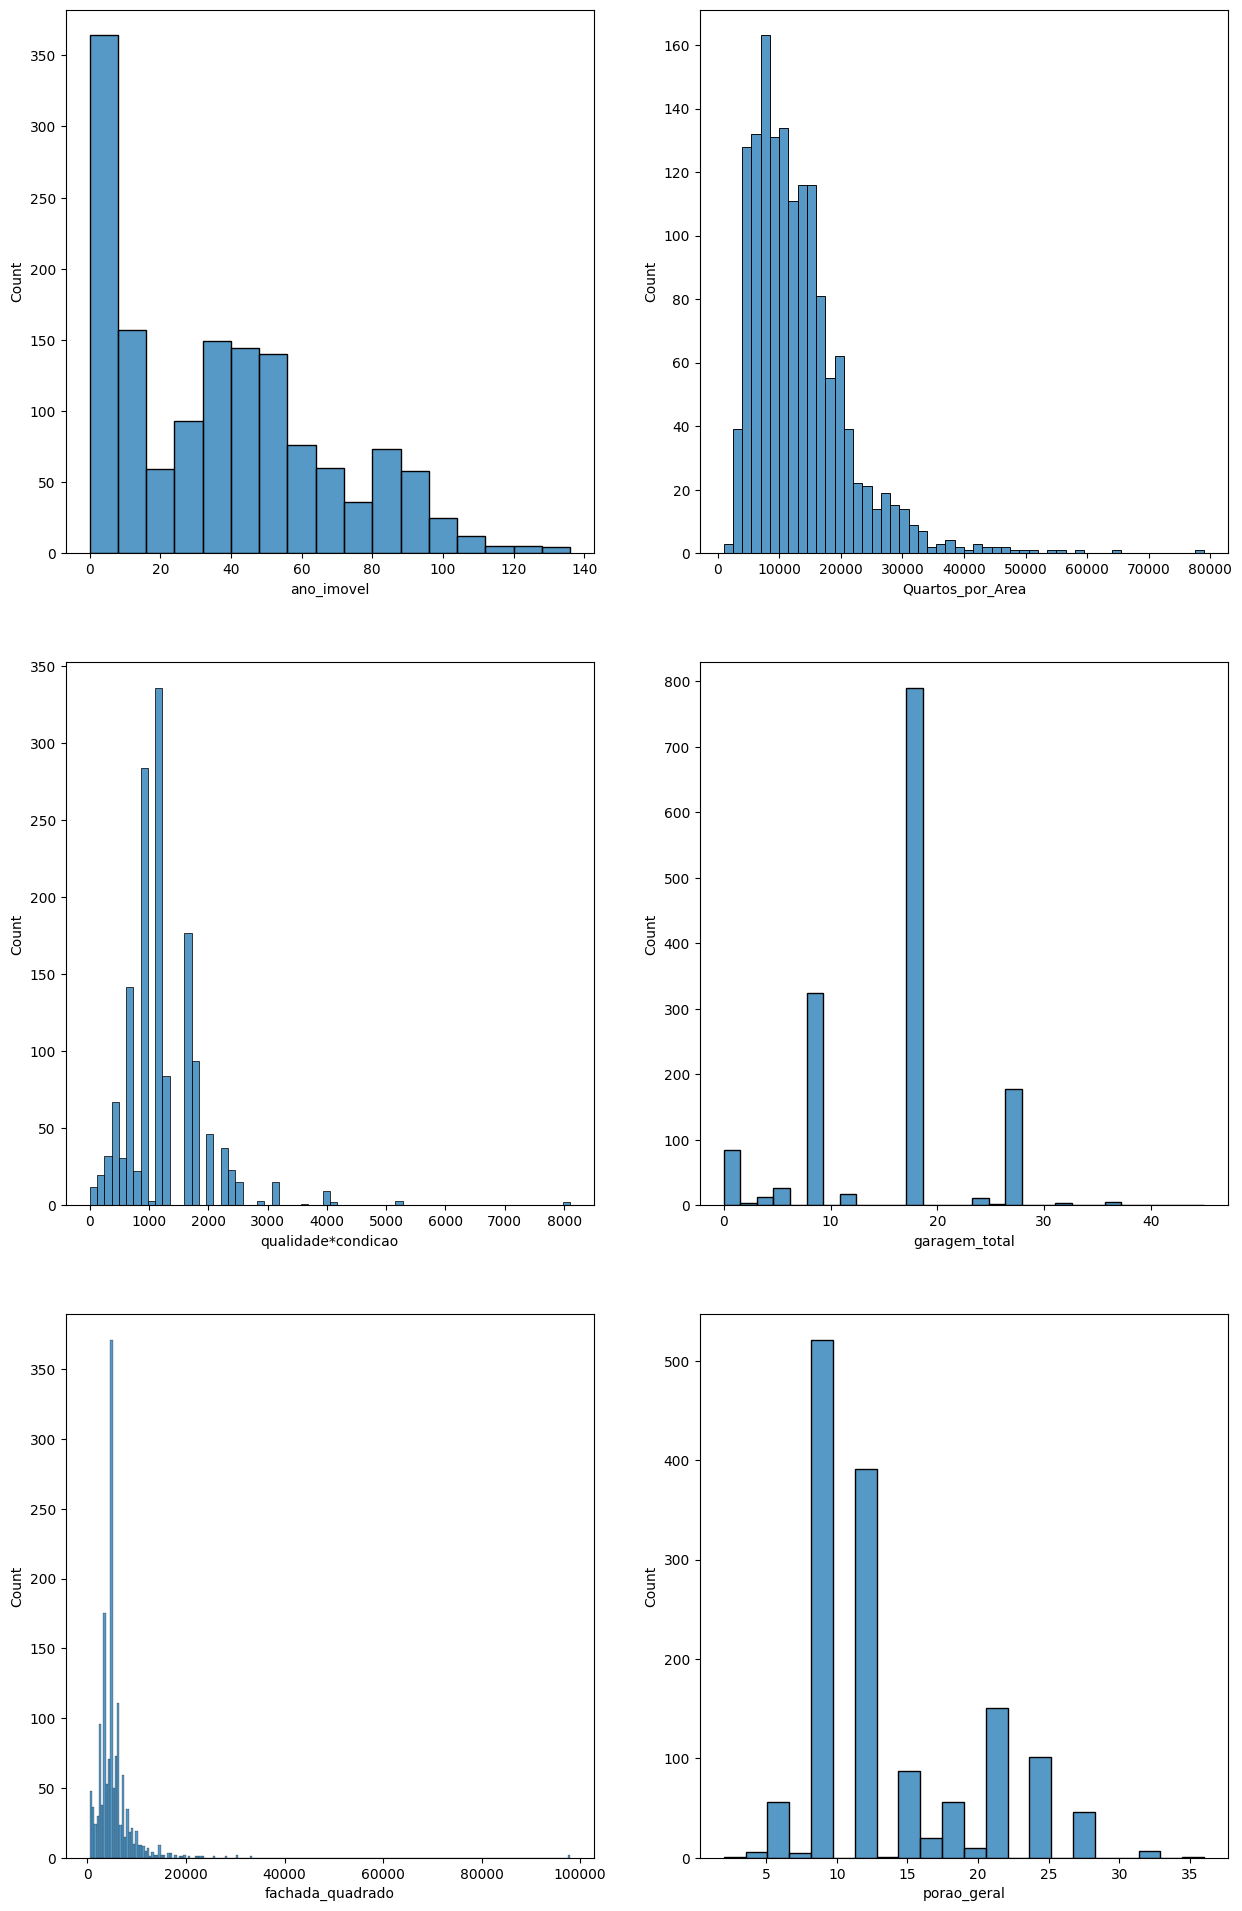

In [70]:
# plotando as novas features 
fig = plt.figure(figsize=(15, 24))

for column in features_consideradas:
  ax = fig.add_subplot(3, 2, features_consideradas.index(column)+1)
  sns.histplot(df_copia_novas_features[column])

## Correlação de Variáveis Categóricas

Para a seleção das variáveis categóricas, vamos utilizar o método de Pearson's Chi-Squared Feature Selection.

Para a seleção, vamos usar a classe SelectKBest, com chi2() como método. 

Fonte: https://machinelearningmastery.com/feature-selection-with-categorical-data/

In [71]:
# criando um df só com as variáveis categóricas
df_categoricas = df_copia.select_dtypes('object')
df_categoricas.head()

,ClasseZona,Rua,FormaProp,PlanoProp,Servicos,ConfigLote,InclinacaoLote,Bairro,Estrada1,Estrada2,...,TipoFundacao,Aquecimento,ArCentral,InstalacaoEletrica,Funcionalidade,LocalGaragem,AcabamentoGaragem,EntradaPavimentada,TipoVenda,CondicaoVenda
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,PConc,GasA,Y,SBrkr,Typ,Attchd,RFn,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,CBlock,GasA,Y,SBrkr,Typ,Attchd,RFn,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,PConc,GasA,Y,SBrkr,Typ,Attchd,RFn,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,BrkTil,GasA,Y,SBrkr,Typ,Detchd,Unf,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,PConc,GasA,Y,SBrkr,Typ,Attchd,RFn,Y,WD,Normal


In [72]:
df_categoricas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ClasseZona          1460 non-null   object
 1   Rua                 1460 non-null   object
 2   FormaProp           1460 non-null   object
 3   PlanoProp           1460 non-null   object
 4   Servicos            1460 non-null   object
 5   ConfigLote          1460 non-null   object
 6   InclinacaoLote      1460 non-null   object
 7   Bairro              1460 non-null   object
 8   Estrada1            1460 non-null   object
 9   Estrada2            1460 non-null   object
 10  TipoHabitacao       1460 non-null   object
 11  EstiloHabitacao     1460 non-null   object
 12  TipoTelhado         1460 non-null   object
 13  MaterialTelhado     1460 non-null   object
 14  Exterior1           1460 non-null   object
 15  Exterior2           1460 non-null   object
 16  TipoFundacao        1460

### Codificando as categorias das features

In [73]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [74]:
# regra para codificar variáveis categóricas
# caso tenha mais que 3 tipos -> label encoding
# Caso contrário -> OHE

labels = []
one_hot_encod = []
x = []
le = LabelEncoder()

#contando categorias de cada feature
# se > 3, guardar em labels
# caso contrário, guardar em one_hot_encod
for coluna in df_categoricas.columns:
  if len(df_categoricas[coluna].value_counts()) > 3:
    labels.append(coluna)
  else:
    one_hot_encod.append(coluna)

df_categoricas_labels = df_categoricas[labels].apply(le.fit_transform) # codifica usando labelencoder
df_categoricas_ohe = pd.get_dummies(df_categoricas[one_hot_encod], drop_first=True) # codifica usando one hot encoder (get dummies)

# unindo tudo em um único DF
df_categoricas_codificadas = pd.concat([df_categoricas_labels, df_categoricas_ohe], axis = 1)

In [75]:
df_categoricas_codificadas

,ClasseZona,FormaProp,PlanoProp,ConfigLote,Bairro,Estrada1,Estrada2,TipoHabitacao,EstiloHabitacao,TipoTelhado,...,CondicaoVenda,Rua_Pave,Servicos_NoSeWa,InclinacaoLote_Mod,InclinacaoLote_Sev,ArCentral_Y,AcabamentoGaragem_RFn,AcabamentoGaragem_Unf,EntradaPavimentada_P,EntradaPavimentada_Y
0,3,3,3,4,5,2,2,0,5,1,...,4,True,False,False,False,True,True,False,False,True
1,3,3,3,2,24,1,2,0,2,1,...,4,True,False,False,False,True,True,False,False,True
2,3,0,3,4,5,2,2,0,5,1,...,4,True,False,False,False,True,True,False,False,True
3,3,0,3,0,6,2,2,0,5,1,...,0,True,False,False,False,True,False,True,False,True
4,3,0,3,2,15,2,2,0,5,1,...,4,True,False,False,False,True,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,3,3,3,4,8,2,2,0,5,1,...,4,True,False,False,False,True,True,False,False,True
1456,3,3,3,4,14,2,2,0,2,1,...,4,True,False,False,False,True,False,True,False,True
1457,3,3,3,4,6,2,2,0,5,1,...,4,True,False,False,False,True,True,False,False,True
1458,3,3,3,4,12,2,2,0,2,3,...,4,True,False,False,False,True,False,True,False,True


In [76]:
print(df.shape[0])
print(df_categoricas_codificadas.shape[0])

1460
1460


### Usando SelectKBest com Chi2

In [77]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = df_categoricas_codificadas[:]
# format all fields as string
X = X.astype(str)

y = df.iloc[:,-1]

# usando a classe SelectKBest com a função chi2
# para saber o valor de chi2 de cada feature
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(df_categoricas_codificadas, y)
df_categoricas_codificadas_fs = fs.transform(X)

In [78]:
df_categoricas_codificadas_fs

array([['3', '3', '3', ..., 'False', 'False', 'True'],
       ['3', '3', '3', ..., 'False', 'False', 'True'],
       ['3', '0', '3', ..., 'False', 'False', 'True'],
       ...,
       ['3', '3', '3', ..., 'False', 'False', 'True'],
       ['3', '3', '3', ..., 'True', 'False', 'True'],
       ['3', '3', '3', ..., 'False', 'False', 'True']], dtype=object)

Feature ClasseZona 0: 113.80313866671392
Feature FormaProp 1: 802.9728965803641
Feature PlanoProp 2: 124.35737919793127
Feature ConfigLote 3: 564.633630132727
Feature Bairro 4: 2194.267106067064
Feature Estrada1 5: 212.61628904438493
Feature Estrada2 6: 27.336481201079035
Feature TipoHabitacao 7: 1951.4782450392913
Feature EstiloHabitacao 8: 812.8877196483194
Feature TipoTelhado 9: 356.05361479933555
Feature MaterialTelhado 10: 229.02974032337056
Feature Exterior1 11: 696.0259061594303
Feature Exterior2 12: 808.6199253519723
Feature TipoFundacao 13: 302.3333920788816
Feature Aquecimento 14: 67.61324080193853
Feature InstalacaoEletrica 15: 213.3710469121106
Feature Funcionalidade 16: 97.51975439295228
Feature LocalGaragem 17: 1025.247371269151
Feature TipoVenda 18: 187.47040404010252
Feature CondicaoVenda 19: 212.58657769186894
Feature Rua_Pave 20: 3.6506013473001335
Feature Servicos_NoSeWa 21: 242.33333333333064
Feature InclinacaoLote_Mod 22: 676.8980207826371
Feature InclinacaoLote_Se

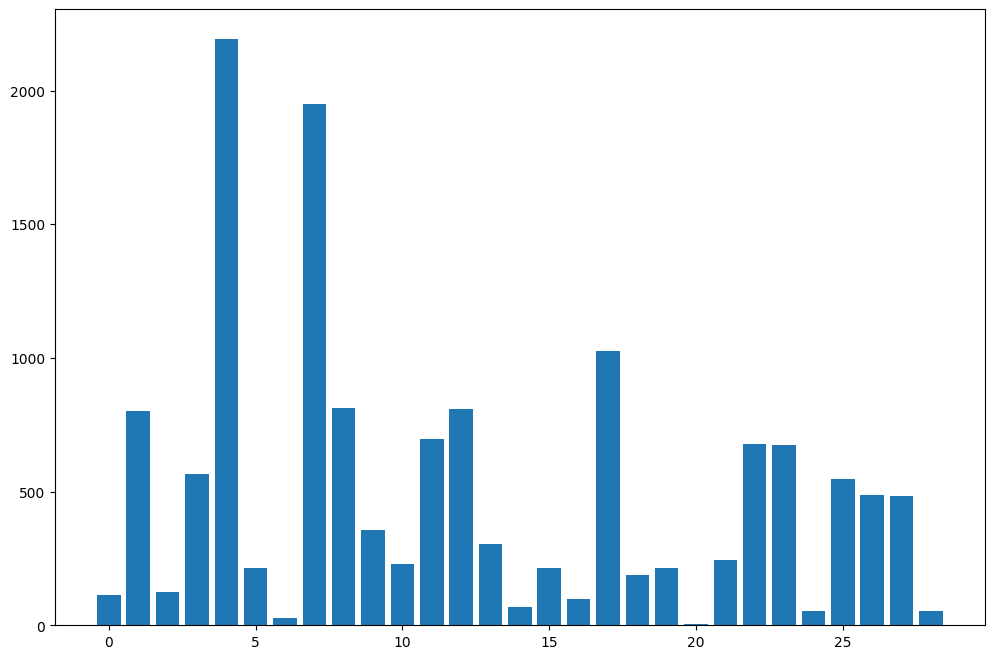

In [79]:
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature {} {}: {}' .format(df_categoricas_codificadas.columns[i], i, fs.scores_[i]))
# plot the scores

plt.figure(figsize = (12, 8))
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

Segundo a análise pelo chi2, as features categóricas que mais são significativas são: Bairro, TipoHabitacao, QualidadeAquecimento e LocalGaragem

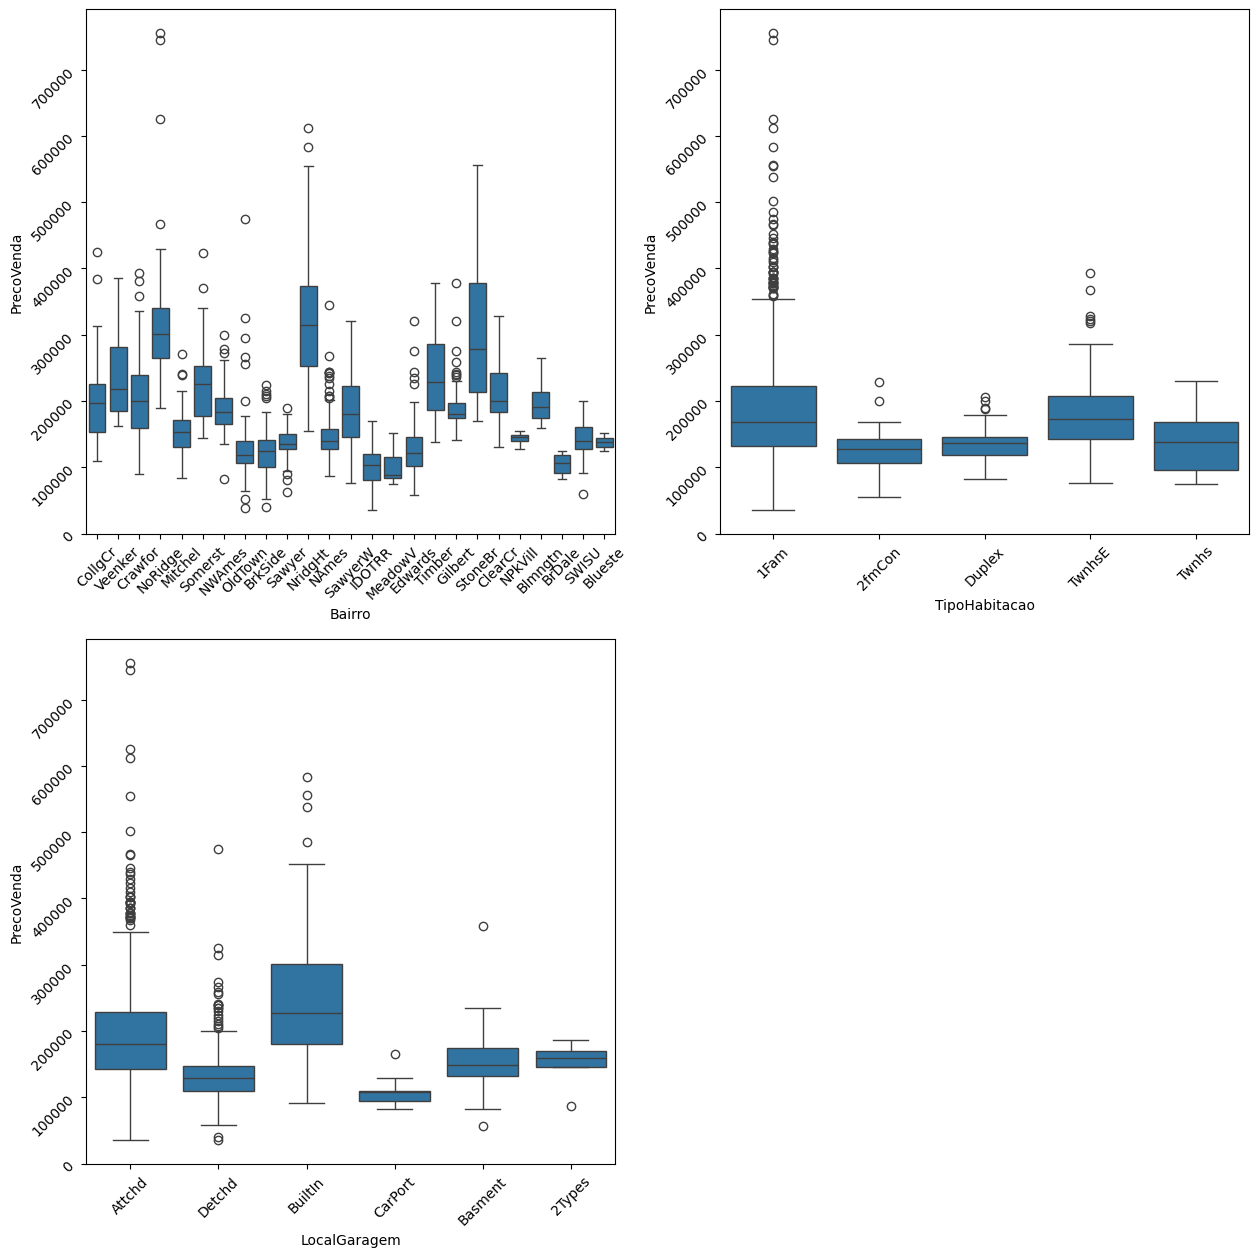

In [80]:
# boxplot das categóricas com maior relação com PrecoVenda
features_object = ['Bairro', 'TipoHabitacao', 'LocalGaragem']

fig = plt.figure(figsize=(15, 15))

for column in features_object:
  ax = fig.add_subplot(2, 2, features_object.index(column)+1)
  sns.boxplot(data = df,
              x = column,
              y = 'PrecoVenda')
  ax.tick_params(rotation=45)

## Entendimento após EDA


 - A distribuição da variável de interesse é assimétrica à direita
 - Após feature engineering, selecionou-se 6 novas features, que possuem menos correlação entre si
 - Entende-se que quanto maior a Área do terreno, maior o valor e que quanto mais antigo, no momento da venda, menor o valor
 - Após avaliação pela função do chi2, verificou-se que as features 'Bairro', 'TipoHabitacao', 'LocalGaragem' são as que mais apresentam relação com a variável de interesse. Então, foram plotados os boxplots delas com a PrecoVenda.
 - Alguns bairros possuem preços consideravelmente maiores que os outros

# Regressão Linear (Objetivo 1)

## Regressão com as features criadas (melhor resultado = 0.81)

In [81]:
# as seis features a serem consideradas serão

features_consideradas = ['ano_imovel','Quartos_por_Area','qualidade*condicao',
                         'garagem_total','fachada_quadrado','porao_geral']

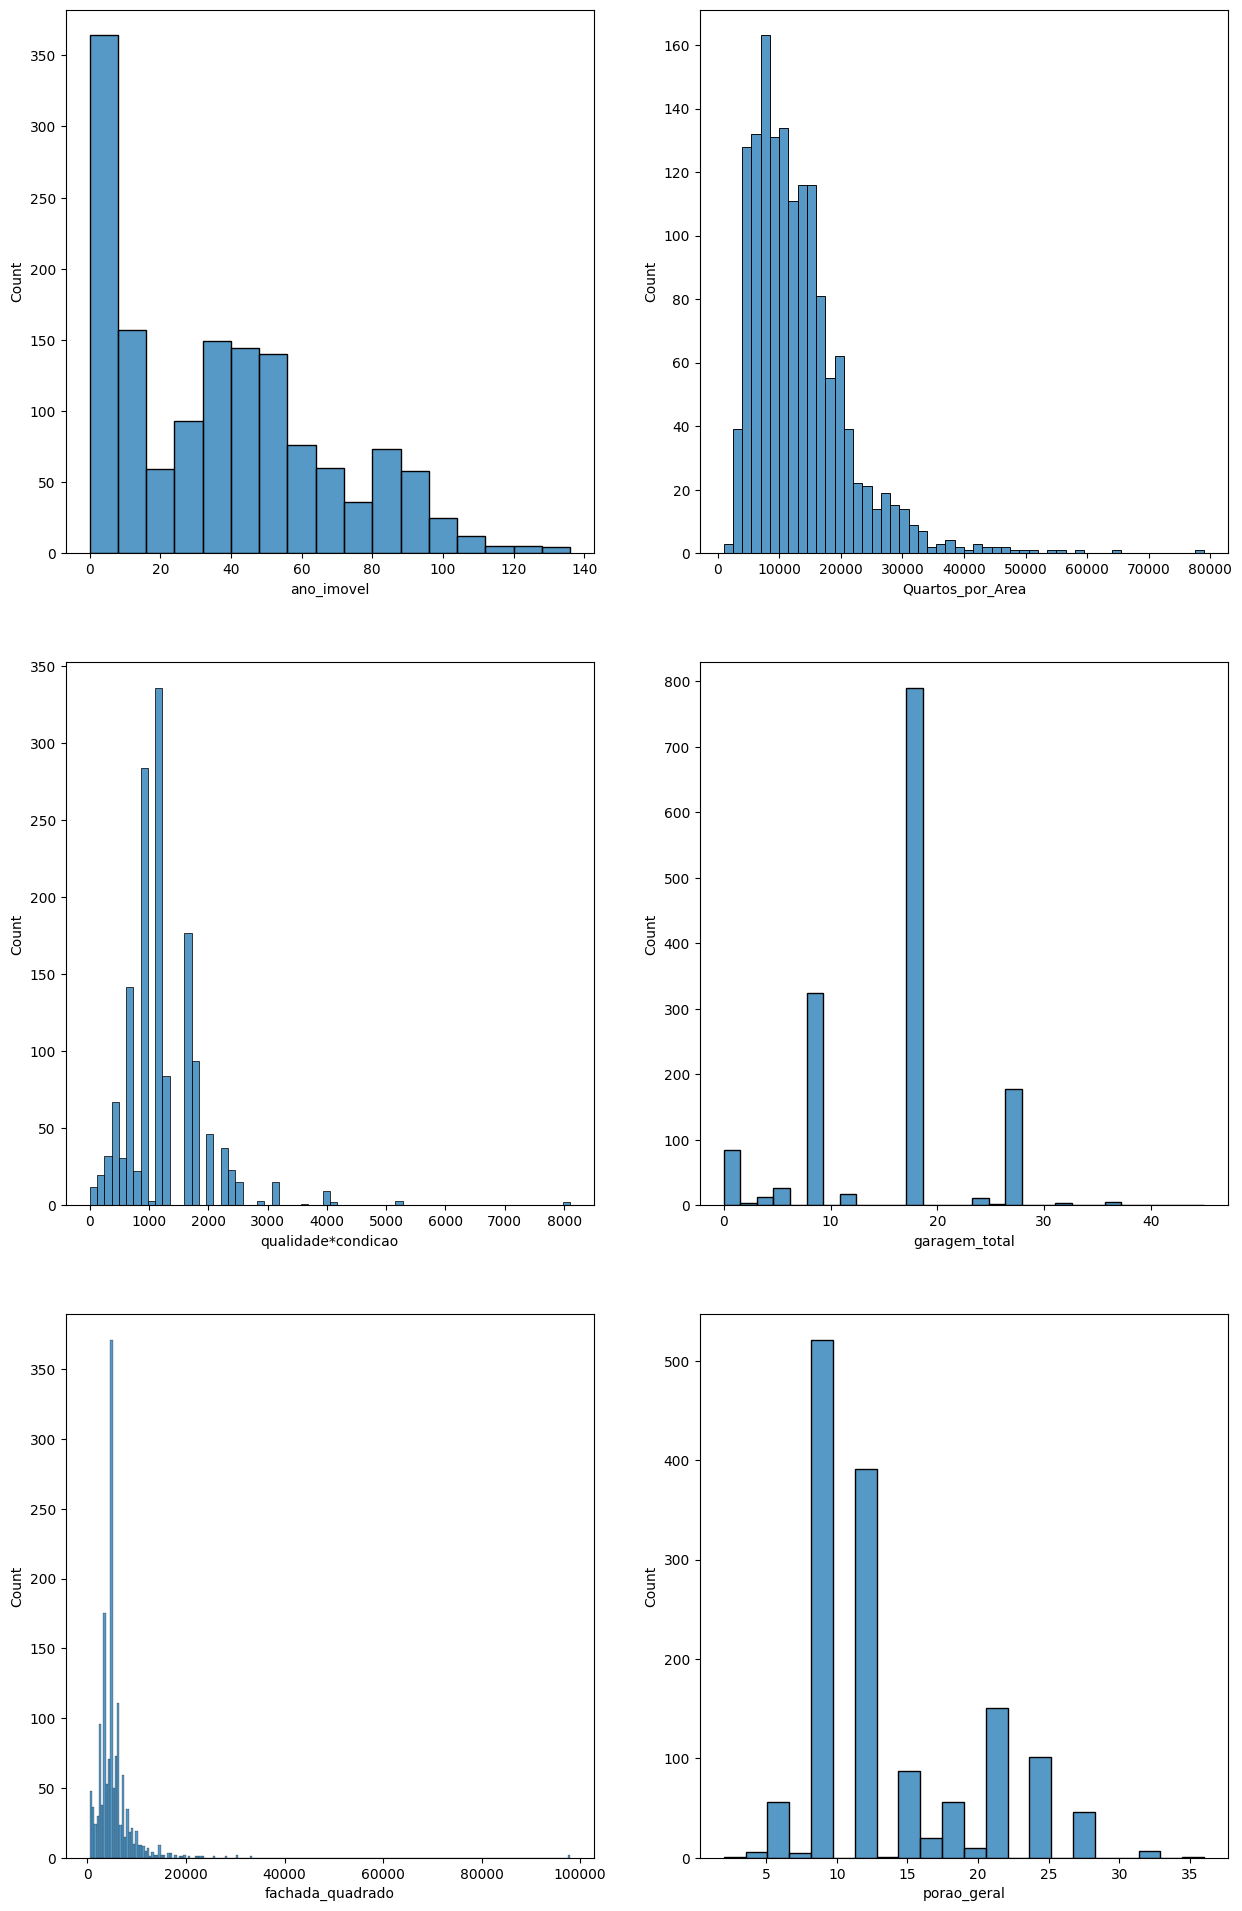

In [82]:
# Distribuição das features importantes

# plotando as features do tipo object com dados vazios
fig = plt.figure(figsize=(15, 24))

for column in features_consideradas:
  ax = fig.add_subplot(3, 2, features_consideradas.index(column)+1)
  sns.histplot(df_copia_novas_features[column])

Vamos aplicar log nas features independentes

In [83]:
# novas features de log
df_copia_novas_features['ano_imovel_log'] = (df_copia_novas_features['ano_imovel']+1).apply(np.log)
df_copia_novas_features['Quartos_por_Area_log'] = (df_copia_novas_features['Quartos_por_Area']+1).apply(np.log)
df_copia_novas_features['qualidade*condicao_log'] = (df_copia_novas_features['qualidade*condicao']+1).apply(np.log)
df_copia_novas_features['fachada_quadrado_log'] = (df_copia_novas_features['fachada_quadrado']+1).apply(np.log)
df_copia_novas_features['porao_geral_log'] = (df_copia_novas_features['porao_geral']+1).apply(np.log)
df_copia_novas_features['garagem_total_log'] = (df_copia_novas_features['garagem_total']+1).apply(np.log)

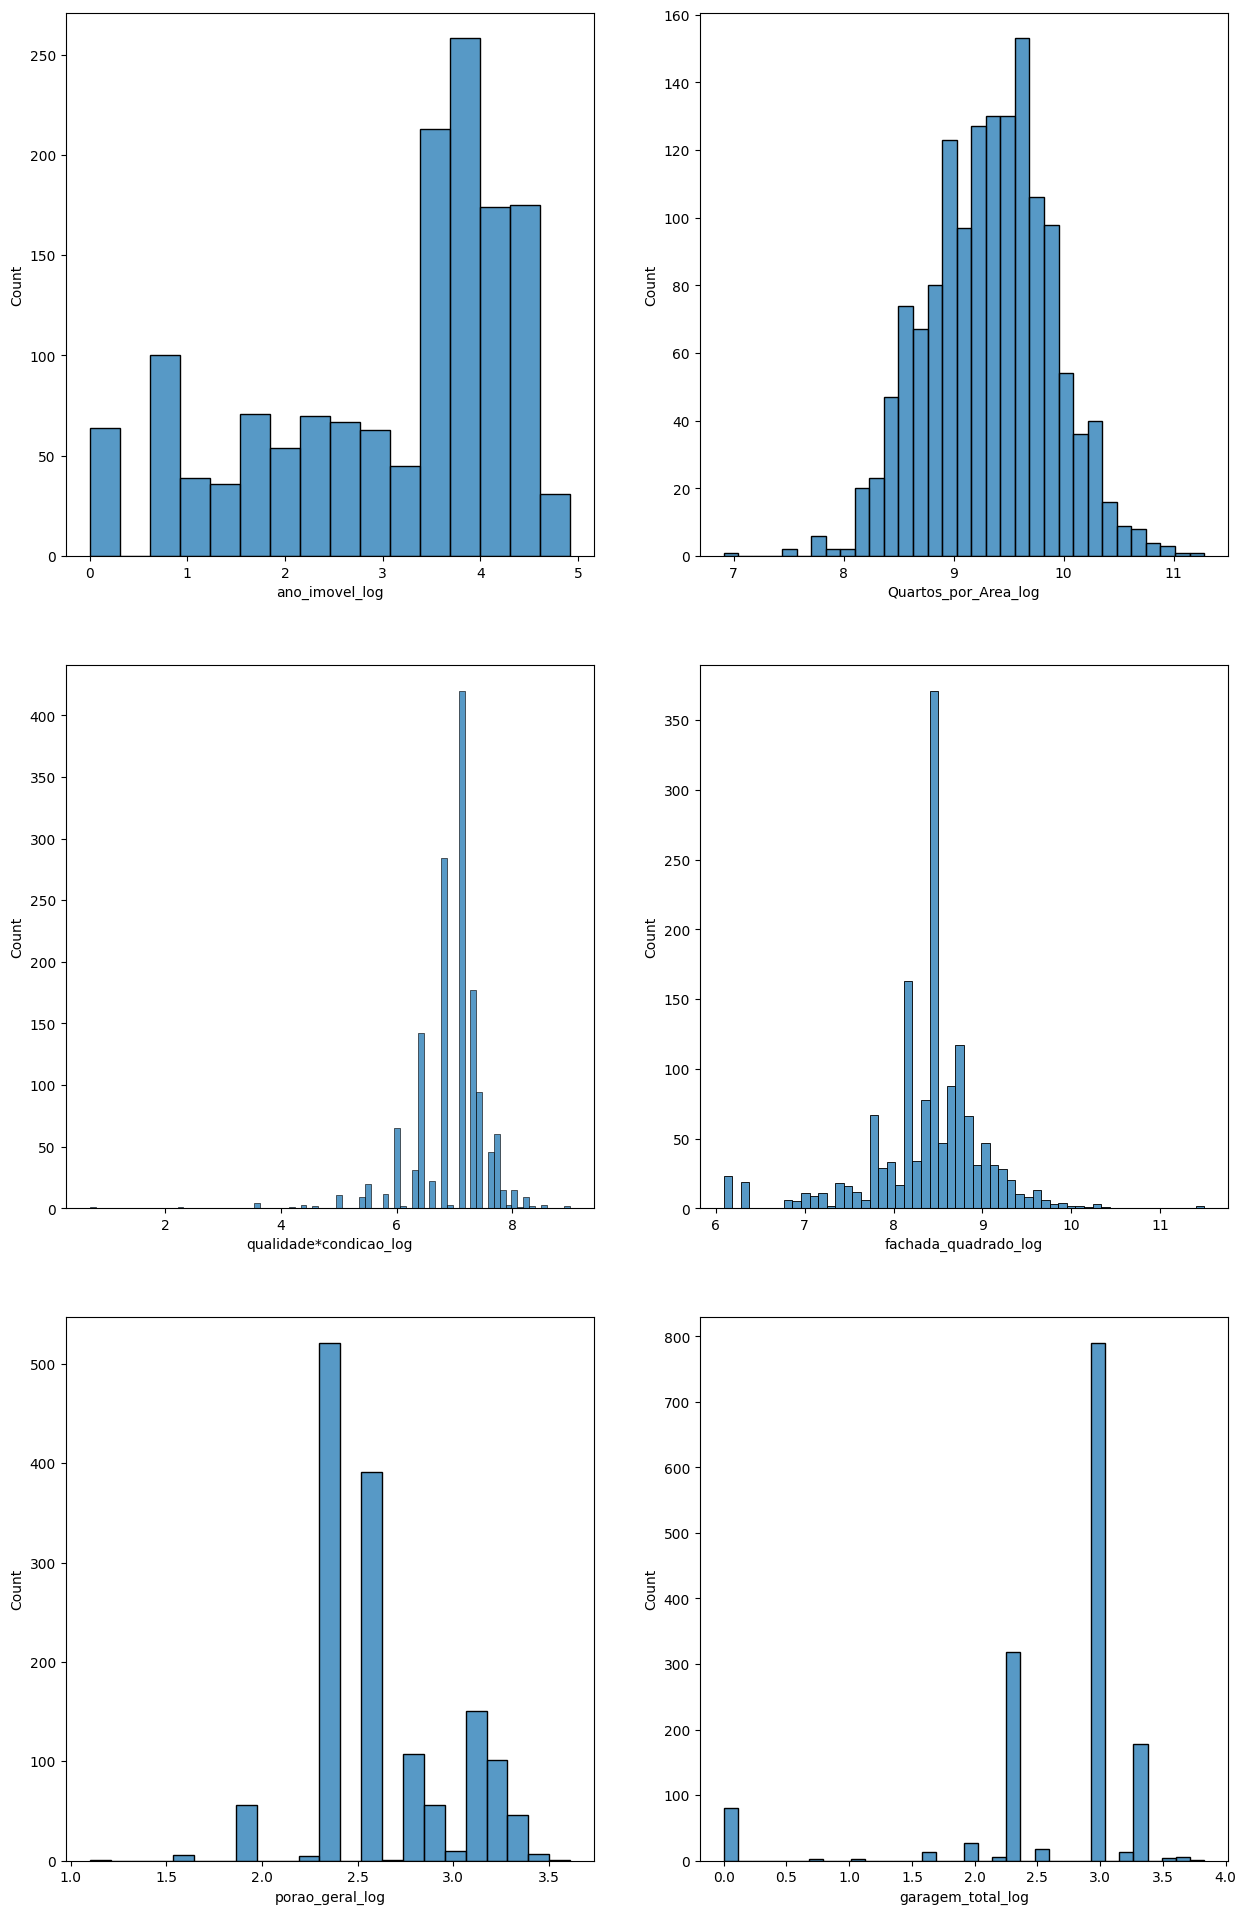

In [84]:
features_consideradas = ['ano_imovel_log', 'Quartos_por_Area_log', 'qualidade*condicao_log',
                         'fachada_quadrado_log','porao_geral_log', 'garagem_total_log']
                         
# plotando as novas features 
fig = plt.figure(figsize=(15, 24))

for column in features_consideradas:
  ax = fig.add_subplot(3, 2, features_consideradas.index(column)+1)
  sns.histplot(df_copia_novas_features[column])

<Axes: xlabel='garagem_total_log', ylabel='PrecoVenda'>

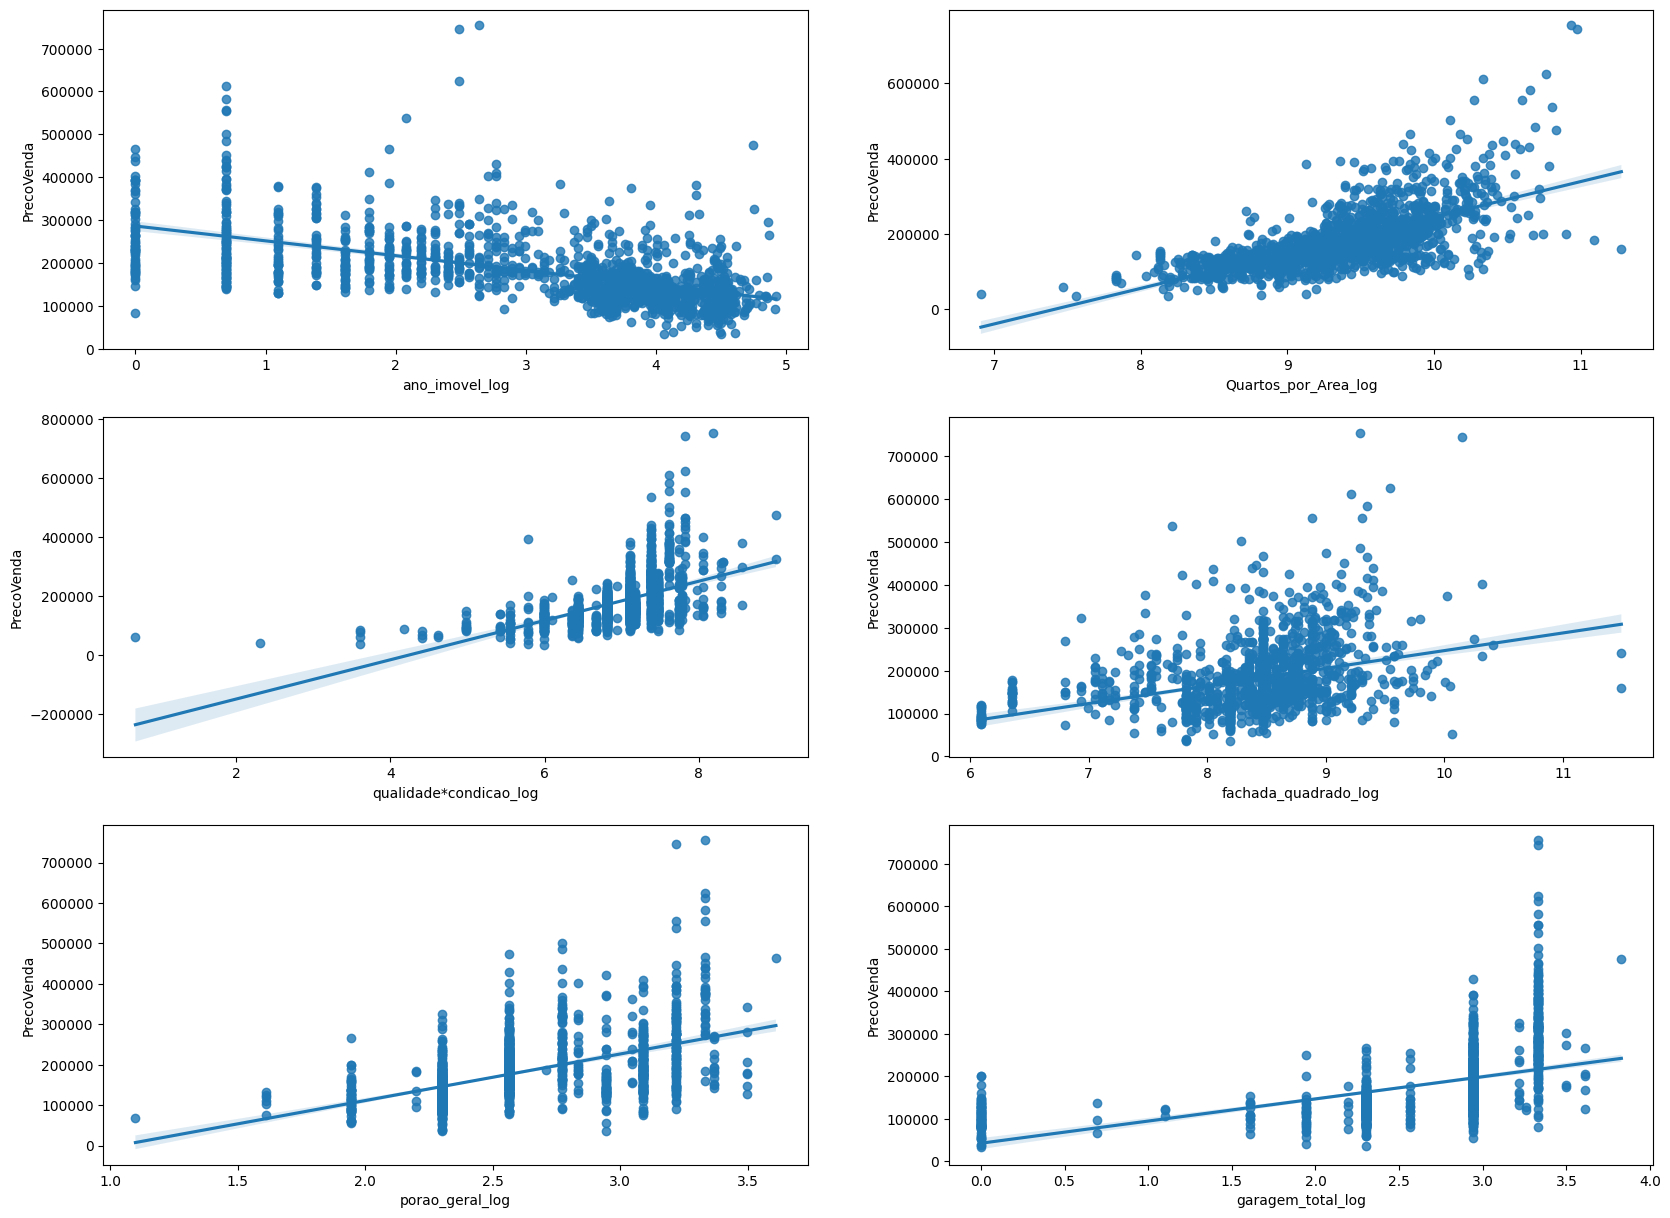

In [85]:
features_consideradas = ['ano_imovel_log', 'Quartos_por_Area_log', 'qualidade*condicao_log',
                         'fachada_quadrado_log','porao_geral_log', 'garagem_total_log']

# Plotando a correlação das features novas com o preço de venda
fig, ax = plt.subplots(3,2,figsize=(20,15))

sns.regplot(x=df_copia_novas_features['ano_imovel_log'],y=df['PrecoVenda'],ax=ax[0,0])
sns.regplot(x=df_copia_novas_features['Quartos_por_Area_log'],y=df['PrecoVenda'],ax=ax[0,1])
sns.regplot(x=df_copia_novas_features['qualidade*condicao_log'],y=df['PrecoVenda'],ax=ax[1,0])
sns.regplot(x=df_copia_novas_features['fachada_quadrado_log'],y=df['PrecoVenda'],ax=ax[1,1])
sns.regplot(x=df_copia_novas_features['porao_geral_log'],y=df['PrecoVenda'],ax=ax[2,0])
sns.regplot(x=df_copia_novas_features['garagem_total_log'],y=df['PrecoVenda'],ax=ax[2,1])

<Axes: xlabel='garagem_total', ylabel='PrecoVenda'>

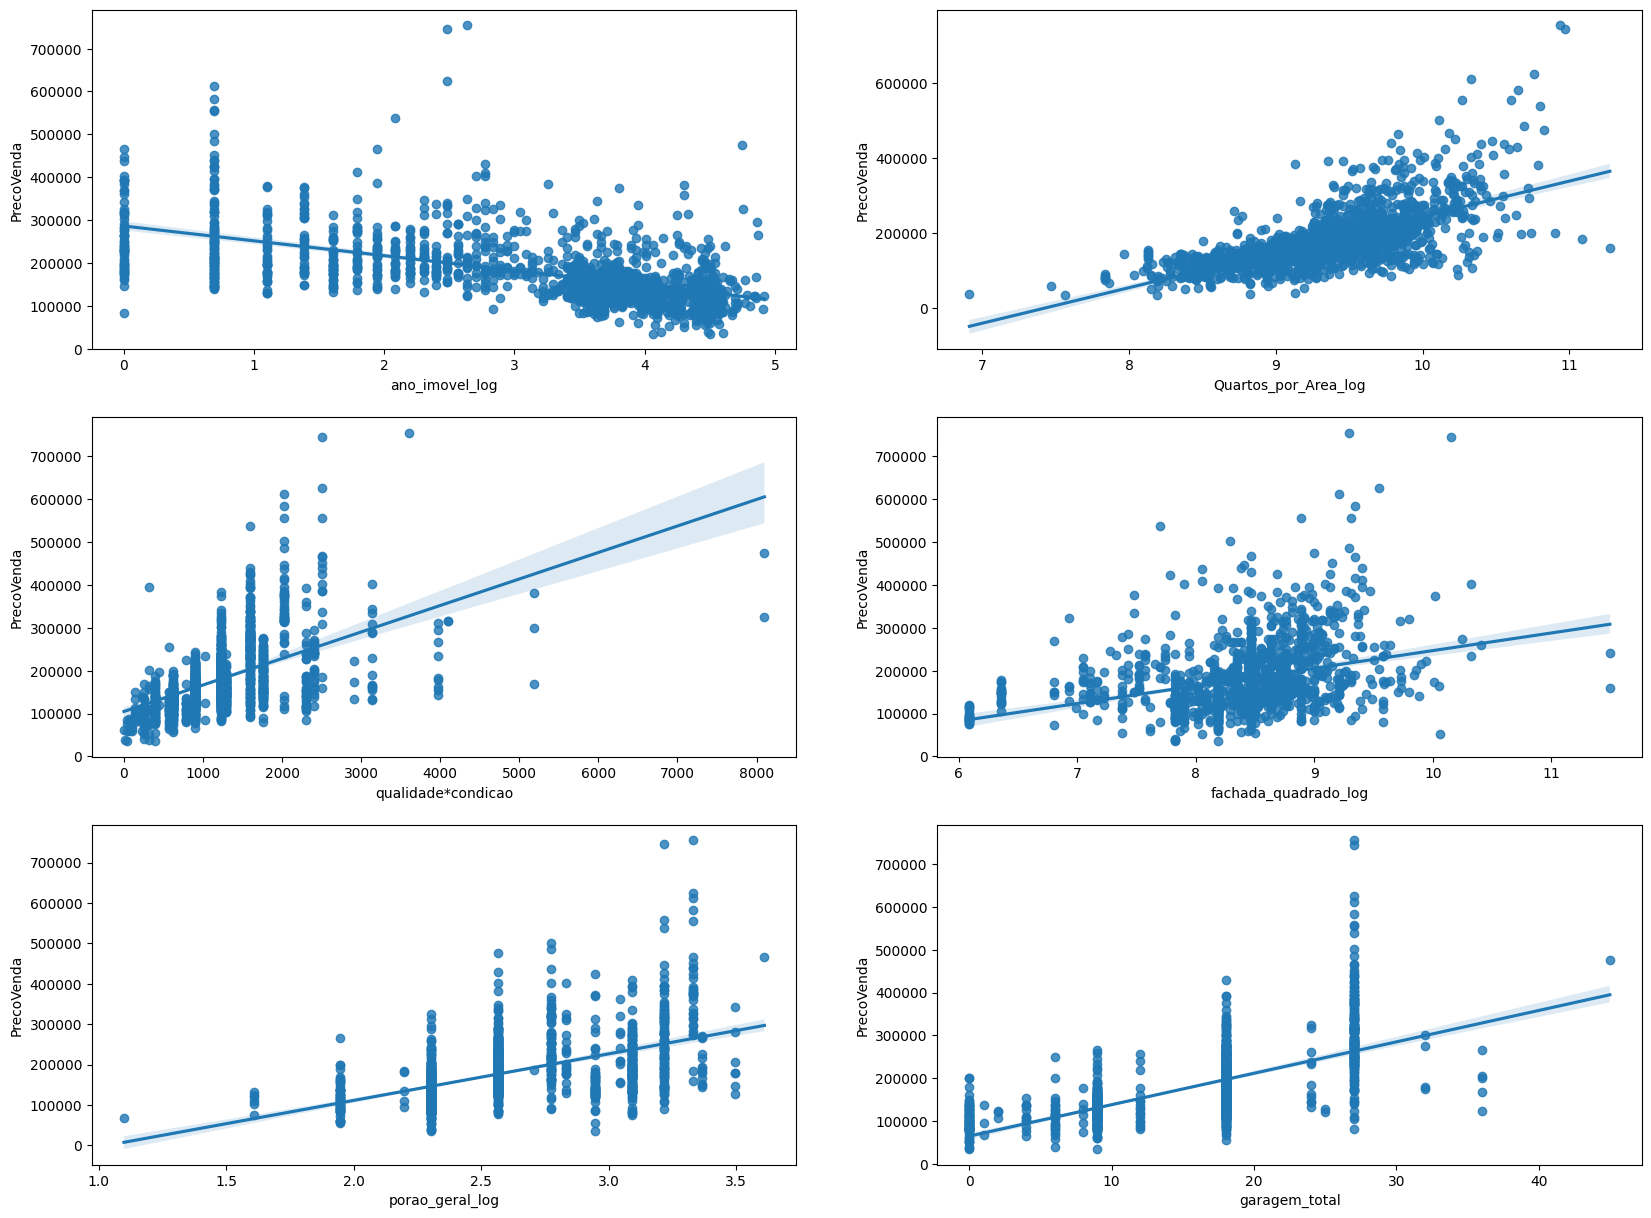

In [86]:
features_consideradas = ['ano_imovel_log', 'Quartos_por_Area_log', 'qualidade*condicao',
                         'fachada_quadrado_log','porao_geral_log', 'garagem_total']

# Plotando a correlação das features novas com o preço de venda
fig, ax = plt.subplots(3,2,figsize=(20,15))

sns.regplot(x=df_copia_novas_features['ano_imovel_log'],y=df['PrecoVenda'],ax=ax[0,0])
sns.regplot(x=df_copia_novas_features['Quartos_por_Area_log'],y=df['PrecoVenda'],ax=ax[0,1])
sns.regplot(x=df_copia_novas_features['qualidade*condicao'],y=df['PrecoVenda'],ax=ax[1,0])
sns.regplot(x=df_copia_novas_features['fachada_quadrado_log'],y=df['PrecoVenda'],ax=ax[1,1])
sns.regplot(x=df_copia_novas_features['porao_geral_log'],y=df['PrecoVenda'],ax=ax[2,0])
sns.regplot(x=df_copia_novas_features['garagem_total'],y=df['PrecoVenda'],ax=ax[2,1])

Na etapa anterior já foram realizadas a limpeza,  preenchimento de dados faltantes e escolha das variáveis de interesse.

Primeiro, vamos ajustar a variável de interesse com log

In [87]:
df_copia_novas_features['PrecoVenda_log'] = df_copia_novas_features['PrecoVenda'].apply(np.log)

<Axes: xlabel='PrecoVenda_log', ylabel='Count'>

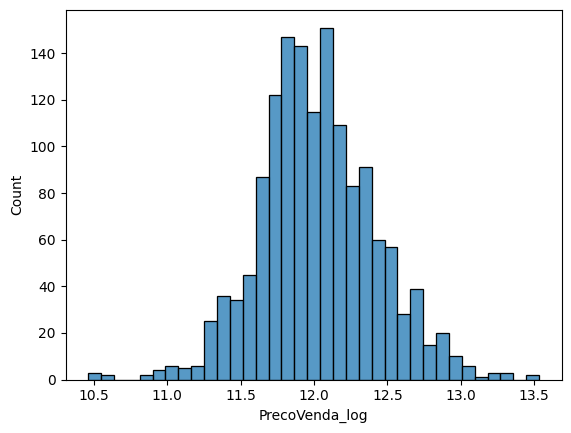

In [88]:
sns.histplot(df_copia_novas_features['PrecoVenda_log'])

In [89]:
import statsmodels.api as sm

In [90]:
features_consideradas = ['ano_imovel_log', 'Quartos_por_Area_log', 'qualidade*condicao_log',
                         'fachada_quadrado_log','porao_geral_log', 'garagem_total_log']

In [91]:
# modelo de regressão com statsmodel
X = df_copia_novas_features[features_consideradas]
y = df_copia_novas_features['PrecoVenda_log']

X = sm.add_constant(X) # adding a constant

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:         PrecoVenda_log   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     1035.
Date:                Fri, 16 Feb 2024   Prob (F-statistic):               0.00
Time:                        11:12:27   Log-Likelihood:                 482.53
No. Observations:                1460   AIC:                            -951.1
Df Residuals:                    1453   BIC:                            -914.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      7

Como 0.805 foi meu score max para r2, vou tentar remover outliers

In [92]:
from scipy import stats

In [93]:
features_consideradas = ['ano_imovel_log', 'Quartos_por_Area_log', 'qualidade*condicao_log',
                         'fachada_quadrado_log','porao_geral_log', 'garagem_total_log']
#columns for z-score calculation
df_num = df_copia_novas_features[features_consideradas] 

#Calculating z-score using stats library
z = np.abs(stats.zscore(df_num))

In [94]:
#Removendo os outliers
df_sem_outliers = df_copia_novas_features[features_consideradas].copy()[(z < 10).all(axis=1)]

print('Linhas, Colunas ANTES de remover outliers : ', df_copia_novas_features[features_consideradas].shape )
print('Linhas, Colunas DEPOIS de remover outliers : ', df_sem_outliers.shape )

Linhas, Colunas ANTES de remover outliers :  (1460, 6)
Linhas, Colunas DEPOIS de remover outliers :  (1460, 6)


Não possui outliers

Vamos tentar MinMAxScaler, então

In [95]:
# importando a biblioteca
from sklearn.preprocessing import MinMaxScaler

In [96]:
features_consideradas = ['ano_imovel_log', 'Quartos_por_Area_log', 'qualidade*condicao_log',
                         'fachada_quadrado_log','porao_geral_log', 'garagem_total_log']

df_num = df_copia_novas_features[features_consideradas] 

In [97]:
scaler = MinMaxScaler()
scaler.fit(df_num)
df_num_scaler = pd.DataFrame(scaler.transform(df_num),columns = features_consideradas)
df_num_scaler.describe()

,ano_imovel_log,Quartos_por_Area_log,qualidade*condicao_log,fachada_quadrado_log,porao_geral_log,garagem_total_log
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,0.619931,0.553496,0.754480,0.427016,0.599482,0.691873
std,0.267606,0.128382,0.075928,0.118588,0.146945,0.195718
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.446592,0.465165,0.735603,0.388375,0.479230,0.601410
50%,0.728360,0.558735,0.772683,0.440116,0.583662,0.769056
75%,0.814502,0.637902,0.804811,0.490223,0.734714,0.769056
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [98]:
# modelo de regressão com statsmodel
X = df_num_scaler
y = df_copia_novas_features['PrecoVenda_log']

X = sm.add_constant(X) # adding a constant

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:         PrecoVenda_log   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     1035.
Date:                Fri, 16 Feb 2024   Prob (F-statistic):               0.00
Time:                        11:12:27   Log-Likelihood:                 482.53
No. Observations:                1460   AIC:                            -951.1
Df Residuals:                    1453   BIC:                            -914.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      9

# Random Forest (Objetivo 2)

## Setando e dividindo o dataset em treino, teste e validação

In [99]:
# importando as bibliotecas para criação do modelo
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [100]:
df_copia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Id                    1460 non-null   int64  
 1   ClasseImovel          1460 non-null   int64  
 2   ClasseZona            1460 non-null   object 
 3   Fachada               1460 non-null   float64
 4   TamanhoLote           1460 non-null   int64  
 5   Rua                   1460 non-null   object 
 6   FormaProp             1460 non-null   object 
 7   PlanoProp             1460 non-null   object 
 8   Servicos              1460 non-null   object 
 9   ConfigLote            1460 non-null   object 
 10  InclinacaoLote        1460 non-null   object 
 11  Bairro                1460 non-null   object 
 12  Estrada1              1460 non-null   object 
 13  Estrada2              1460 non-null   object 
 14  TipoHabitacao         1460 non-null   object 
 15  EstiloHabitacao      

In [101]:
df_num = df_copia.select_dtypes(exclude='object').drop('Id', axis=1)
df_num.head()

,ClasseImovel,Fachada,TamanhoLote,Qualidade,Condicao,AnoConstrucao,AnoReforma,AreaAlvenaria,QualidadeCobertura,CondicaoExterna,...,AreaDeck,AreaVarandaAberta,AreaVarandaFechada,AreaVaranda3Estacoes,AreaAlpendre,AreaPiscina,ValorOutros,MesVenda,AnoVenda,PrecoVenda
0,60,65.0,8450,7,5,2003,2003,196.0,4,3,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,3,3,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,4,3,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,3,3,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,4,3,...,192,84,0,0,0,0,0,12,2008,250000


In [102]:
df_num.shape

(1460, 48)

In [103]:
df_categoricas_codificadas.shape

(1460, 29)

In [104]:
# unindo os dois datasets, um com numéricas, e outro com categóricas codificadas
df_copia_rfr = pd.concat([df_num,df_categoricas_codificadas],axis=1).drop('PrecoVenda',axis=1)
df_copia_rfr

,ClasseImovel,Fachada,TamanhoLote,Qualidade,Condicao,AnoConstrucao,AnoReforma,AreaAlvenaria,QualidadeCobertura,CondicaoExterna,...,CondicaoVenda,Rua_Pave,Servicos_NoSeWa,InclinacaoLote_Mod,InclinacaoLote_Sev,ArCentral_Y,AcabamentoGaragem_RFn,AcabamentoGaragem_Unf,EntradaPavimentada_P,EntradaPavimentada_Y
0,60,65.0,8450,7,5,2003,2003,196.0,4,3,...,4,True,False,False,False,True,True,False,False,True
1,20,80.0,9600,6,8,1976,1976,0.0,3,3,...,4,True,False,False,False,True,True,False,False,True
2,60,68.0,11250,7,5,2001,2002,162.0,4,3,...,4,True,False,False,False,True,True,False,False,True
3,70,60.0,9550,7,5,1915,1970,0.0,3,3,...,0,True,False,False,False,True,False,True,False,True
4,60,84.0,14260,8,5,2000,2000,350.0,4,3,...,4,True,False,False,False,True,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,1999,2000,0.0,3,3,...,4,True,False,False,False,True,True,False,False,True
1456,20,85.0,13175,6,6,1978,1988,119.0,3,3,...,4,True,False,False,False,True,False,True,False,True
1457,70,66.0,9042,7,9,1941,2006,0.0,5,4,...,4,True,False,False,False,True,True,False,False,True
1458,20,68.0,9717,5,6,1950,1996,0.0,3,3,...,4,True,False,False,False,True,False,True,False,True


In [105]:
# separando o dataset em treino, validação e teste para o dataset

X = df_copia_rfr.copy()
y = df_copia_novas_features['PrecoVenda_log']

# Primeiro, separando em treino e test_val (teste + validação)
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size = 0.30, random_state = 42)

# Agora, separando test_val em test e valid
X_test, X_valid, y_test, y_valid = train_test_split(X_test_val, y_test_val, test_size = 0.50, random_state = 42)

print('Tamanho do treino X: {} e y: {}'.format(len(X_train),len(y_train)))
print('Tamanho do teste X: {} e y: {}'.format(len(X_test),len(y_test)))
print('Tamanho do valid X: {} e y: {}'.format(len(X_valid),len(y_valid)))

Tamanho do treino X: 1022 e y: 1022
Tamanho do teste X: 219 e y: 219
Tamanho do valid X: 219 e y: 219


In [106]:
# rodando o RandomForest para todo o dataset
rfr = RandomForestRegressor(n_estimators = 150,
                             random_state=42)

rfr.fit(X_train, y_train)
y_pred_valid = rfr.predict(X_valid)
print('O valor de r2 é: {}'.format(rfr.score(X_valid,y_valid)))

O valor de r2 é: 0.9014496041400432


In [107]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_valid, y_pred_valid))  
print('Mean Squared Error:', metrics.mean_squared_error(y_valid, y_pred_valid))  

Mean Absolute Error: 0.09050019372653463
Mean Squared Error: 0.015914336406453303


Para todas as features e n_estimators = 150, temos r2 = 0.9011

## Feature importances

In [108]:
from sklearn.inspection import permutation_importance

In [109]:
rfr = RandomForestRegressor(n_estimators=100)
rfr.fit(X_train, y_train)

RandomForestRegressor()

In [110]:
rfr.feature_importances_

array([2.43548839e-03, 5.94884221e-03, 1.95825418e-02, 5.51011301e-01,
       9.62997729e-03, 1.15645596e-02, 8.85096022e-03, 2.30813686e-03,
       1.59056388e-03, 2.39194118e-03, 7.71324059e-03, 6.46796434e-04,
       2.16896526e-03, 3.91272137e-03, 2.19881852e-02, 2.55633786e-04,
       4.28477049e-04, 5.56445386e-03, 3.93674216e-02, 3.15436666e-03,
       1.94754900e-02, 9.46059156e-03, 3.51968352e-05, 1.00096297e-01,
       5.93102808e-04, 1.07054334e-04, 1.00287548e-03, 5.57795696e-04,
       2.14204966e-03, 1.34287301e-03, 2.54786513e-03, 2.51089371e-03,
       7.00783235e-03, 4.91144473e-03, 4.32785112e-02, 3.13987408e-02,
       4.01963878e-04, 1.61552214e-04, 4.08564808e-03, 4.95666818e-03,
       8.22847288e-04, 4.43368699e-05, 1.00961224e-03, 3.73036794e-05,
       1.02974748e-04, 3.73465394e-03, 1.79008341e-03, 3.62894115e-03,
       1.48680052e-03, 1.94929454e-03, 7.35517031e-04, 5.83638924e-03,
       9.22506529e-04, 1.57463917e-04, 5.11594662e-04, 1.05157505e-03,
      

<BarContainer object of 76 artists>

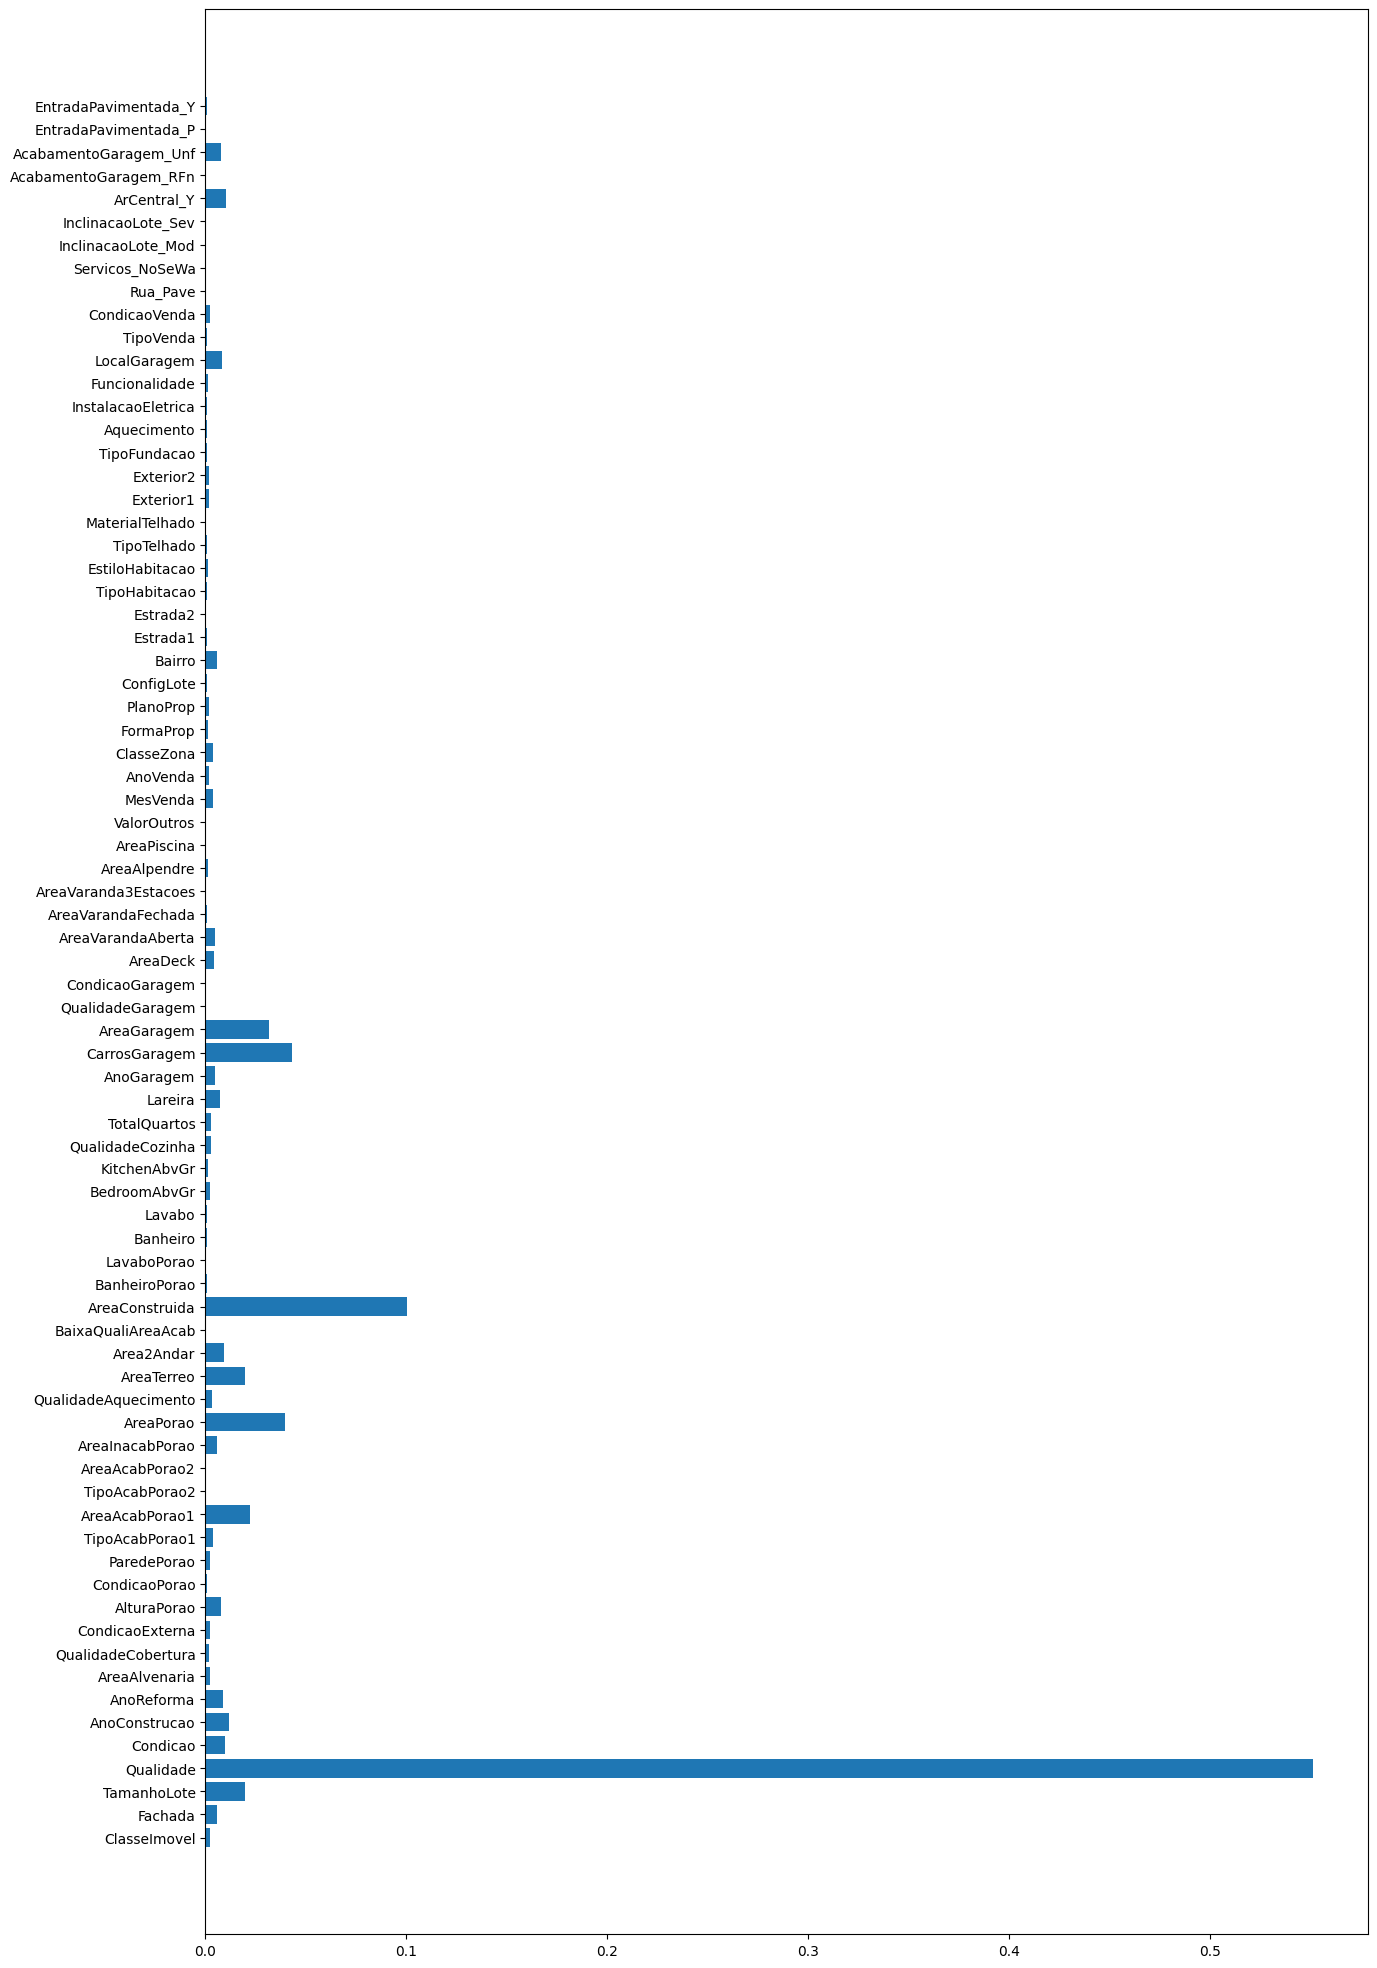

In [111]:
plt.figure(figsize=(15,25))
plt.barh(df_copia_rfr.columns, rfr.feature_importances_)

Text(0.5, 0, 'Random Forest Feature Importance')

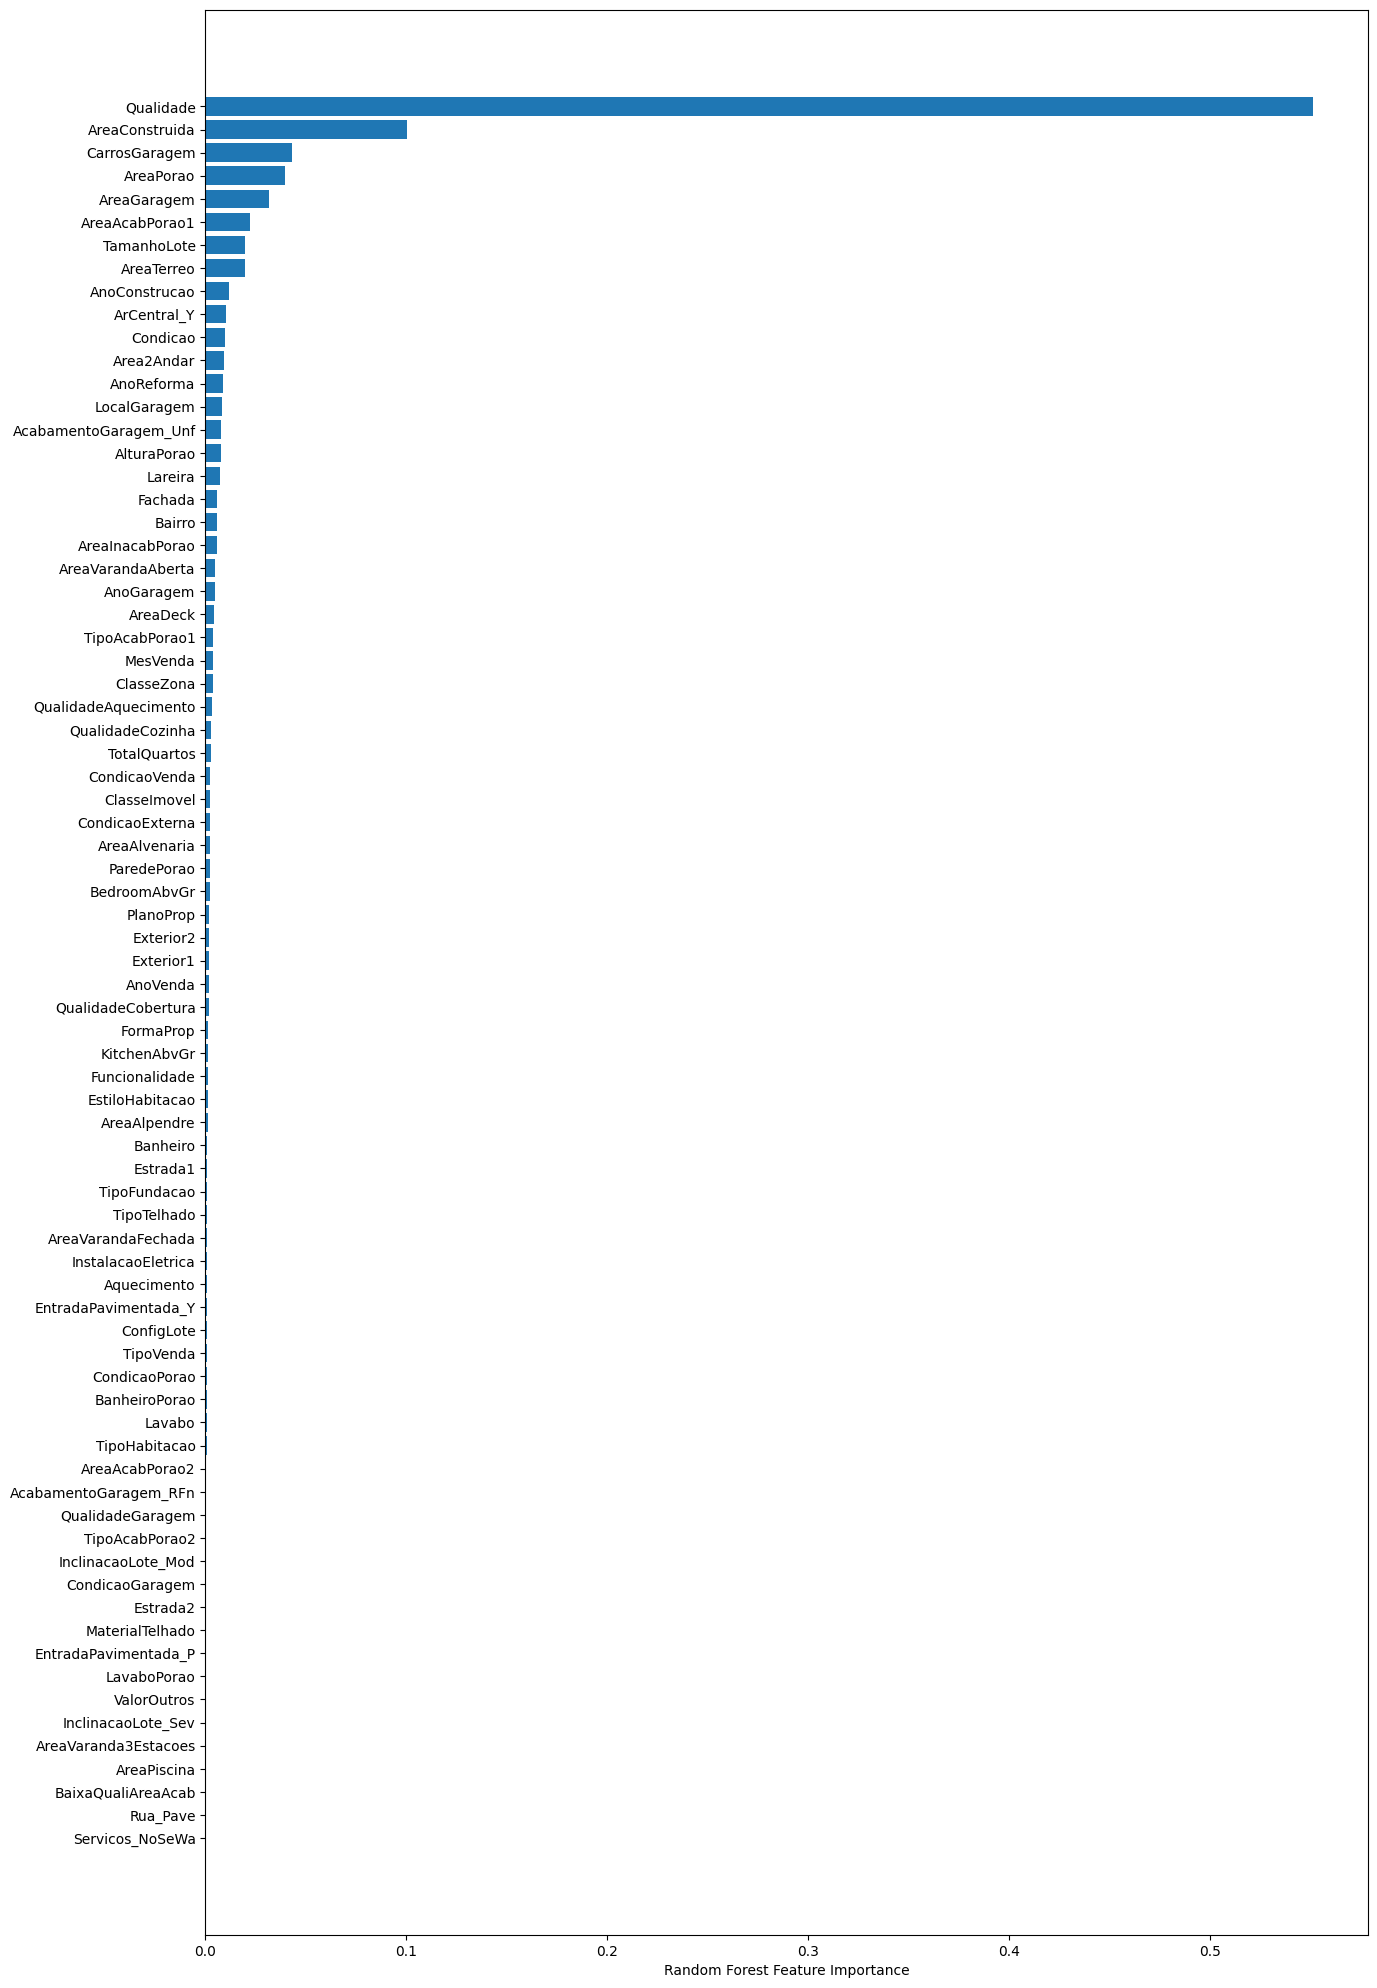

In [112]:
plt.figure(figsize=(15,25))

sorted_idx = rfr.feature_importances_.argsort()
plt.barh(df_copia_rfr.columns[sorted_idx], rfr.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [113]:
sorted_idx = rfr.feature_importances_.argsort()
features_40_mais_importantes = df_copia_rfr.columns[sorted_idx][-40:].tolist()

In [114]:
features_40_mais_importantes

['QualidadeCobertura',
 'AnoVenda',
 'Exterior1',
 'Exterior2',
 'PlanoProp',
 'BedroomAbvGr',
 'ParedePorao',
 'AreaAlvenaria',
 'CondicaoExterna',
 'ClasseImovel',
 'CondicaoVenda',
 'TotalQuartos',
 'QualidadeCozinha',
 'QualidadeAquecimento',
 'ClasseZona',
 'MesVenda',
 'TipoAcabPorao1',
 'AreaDeck',
 'AnoGaragem',
 'AreaVarandaAberta',
 'AreaInacabPorao',
 'Bairro',
 'Fachada',
 'Lareira',
 'AlturaPorao',
 'AcabamentoGaragem_Unf',
 'LocalGaragem',
 'AnoReforma',
 'Area2Andar',
 'Condicao',
 'ArCentral_Y',
 'AnoConstrucao',
 'AreaTerreo',
 'TamanhoLote',
 'AreaAcabPorao1',
 'AreaGaragem',
 'AreaPorao',
 'CarrosGaragem',
 'AreaConstruida',
 'Qualidade']

## Tunando nosso modelo

Agora, usando somente as 40 features mais importantes

In [115]:
# separando o dataset em treino, validação e teste para o dataset

X = df_copia_rfr[features_40_mais_importantes].copy()
y = df_copia_novas_features['PrecoVenda_log']

# Primeiro, separando em treino e test_val (teste + validação)
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size = 0.30, random_state = 42)

# Agora, separando test_val em test e valid
X_test, X_valid, y_test, y_valid = train_test_split(X_test_val, y_test_val, test_size = 0.50, random_state = 42)

print('Tamanho do treino X: {} e y: {}'.format(len(X_train),len(y_train)))
print('Tamanho do teste X: {} e y: {}'.format(len(X_test),len(y_test)))
print('Tamanho do valid X: {} e y: {}'.format(len(X_valid),len(y_valid)))

Tamanho do treino X: 1022 e y: 1022
Tamanho do teste X: 219 e y: 219
Tamanho do valid X: 219 e y: 219


### n_estimator (10, 30, 50, 70, 100, 150, 200)

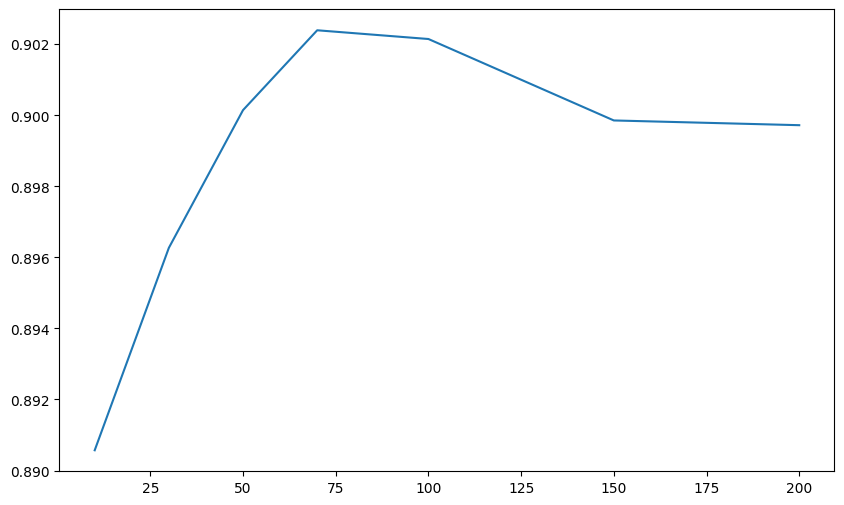

In [116]:
estimators = [10, 30, 50, 70, 100, 150, 200]
scores = []

for est in estimators:
  rfr = RandomForestRegressor(n_estimators = est,
                              random_state=42)

  rfr.fit(X_train, y_train)
  y_pred_valid = rfr.predict(X_valid)
  scores.append(rfr.score(X_valid,y_valid))

plt.figure(figsize = (10,6))
ax = sns.lineplot(x = estimators,
                  y = scores)

Vemos que o valor de n_estimator que dá melhor r2 é 75 e 100. Vamos usar 75

### max_features ('sqrt', 0.1 até 0.6)

[0.8974381160702274, 0.8992940583122416, 0.8978845412641955, 0.900402135293168, 0.9031298251568048, 0.9015647851251096, 0.9027520906369332]


[(0.8974381160702274, 0.9031298251568048)]

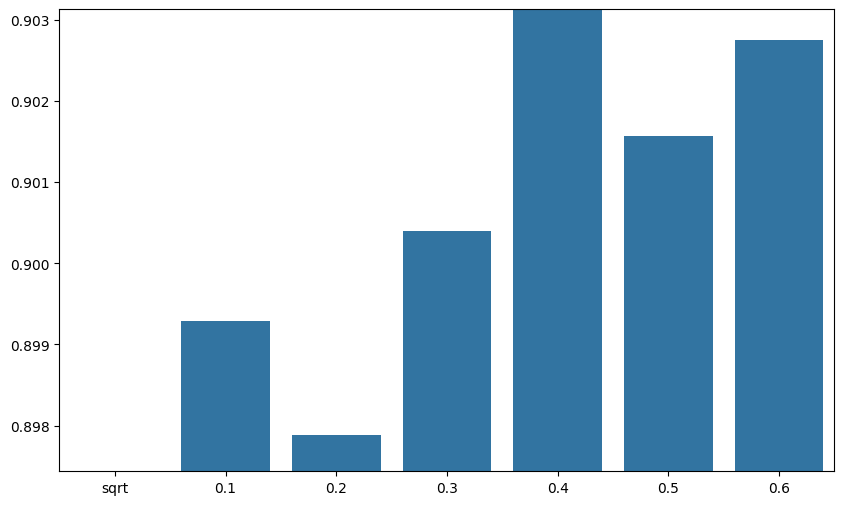

In [117]:
max_f = ['sqrt',0.1,0.2,0.3,0.4,0.5,0.6]

scores = []

for mx in max_f:
  rfr = RandomForestRegressor(n_estimators = 75,
                              max_features = mx,
                              random_state=42)

  rfr.fit(X_train, y_train)
  y_pred_valid = rfr.predict(X_valid)
  scores.append(rfr.score(X_valid,y_valid))
print(scores)

plt.figure(figsize = (10,6))
ax = sns.barplot(y = scores,
                 x = max_f)
ax.set(ylim=(min(scores), max(scores)))

Temos que 0.5 obteve o melhor resultado

### min_samples_leaf(1 até 15)

[0.9015647851251096, 0.904904628489663, 0.902372972361565, 0.8980939248191349, 0.8909947372703539, 0.8910283090565119, 0.8853125765753714, 0.8783707428579052, 0.8772210991271887, 0.8773576744395885, 0.8753180296543991, 0.8715361144155617, 0.8658118162420523, 0.8621702379969172, 0.8588056374837827]


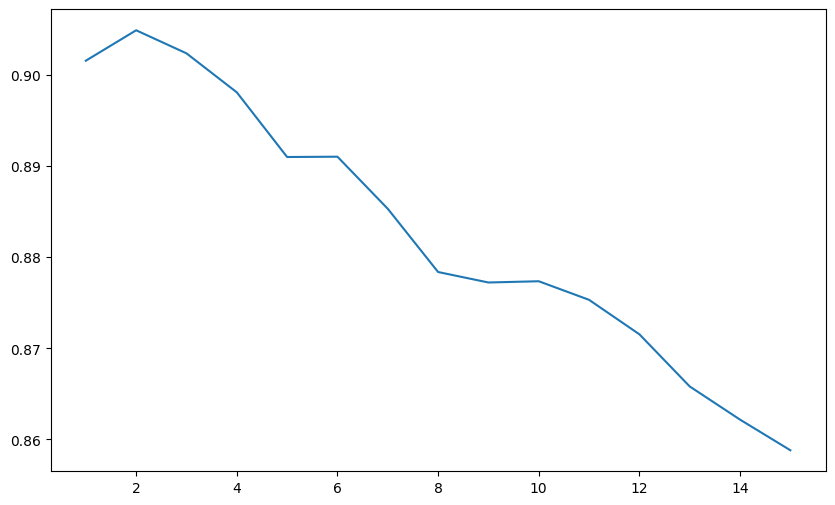

In [118]:
scores = []

for i in range(15):
  rfr = RandomForestRegressor(n_estimators = 75,
                              max_features = 0.5,
                              min_samples_leaf = i+1,
                              random_state=42)

  rfr.fit(X_train, y_train)
  y_pred_valid = rfr.predict(X_valid)
  scores.append(rfr.score(X_valid,y_valid))
print(scores)

plt.figure(figsize = (10,6))
ax = sns.lineplot(x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],
                  y = scores)

Para min_samples_leaf, 1 deu o melhor resultado

### Verificação final para Validação e Teste

In [119]:
# Para validação

rfr = RandomForestRegressor(n_estimators = 75,
                            max_features = 0.5,
                            min_samples_leaf = 1,
                            random_state=42)

rfr.fit(X_train, y_train)
y_pred_valid = rfr.predict(X_valid)
scores.append(rfr.score(X_valid,y_valid))
print('O resultado para r2 é:', round(rfr.score(X_valid,y_valid),4))
print('Mean Absolute Error:', round(metrics.mean_absolute_error(y_valid, y_pred_valid),4))  
print('Mean Squared Error:', round(metrics.mean_squared_error(y_valid, y_pred_valid),4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_valid, y_pred_valid)),4))

O resultado para r2 é: 0.9016
Mean Absolute Error: 0.091
Mean Squared Error: 0.0159
RMSE: 0.1261


In [120]:
# Para o TEste

rfr = RandomForestRegressor(n_estimators = 75,
                            max_features = 0.5,
                            min_samples_leaf = 1,
                            random_state=42)

rfr.fit(X_train, y_train)
y_pred_test = rfr.predict(X_test)
print('O resultado para r2 é:', round(rfr.score(X_test,y_test),4))
print('Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, y_pred_test),4))  
print('Mean Squared Error:', round(metrics.mean_squared_error(y_test, y_pred_test),4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)),4))

O resultado para r2 é: 0.8764
Mean Absolute Error: 0.0917
Mean Squared Error: 0.0217
RMSE: 0.1473


### Relação entre previstos vs reais

Text(0, 0.5, 'real')

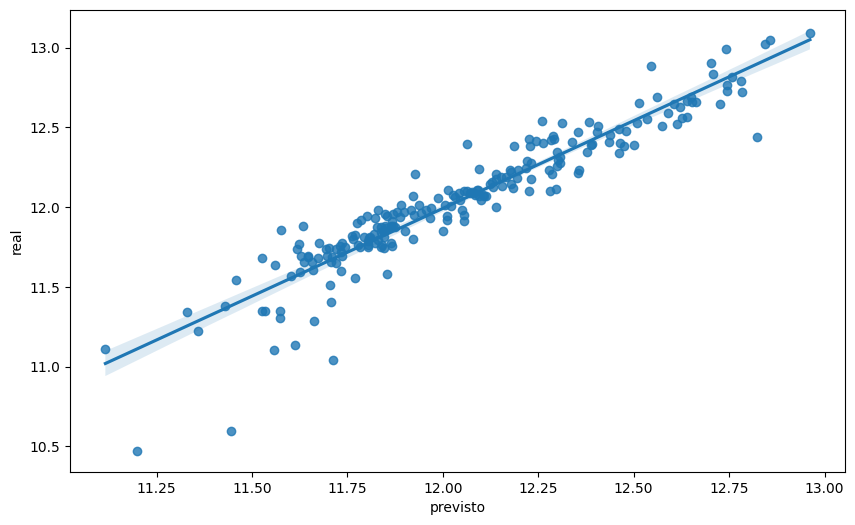

In [121]:
plt.figure(figsize=(10,6))

ax = sns.regplot(x = y_pred_test,
                     y = y_test)
ax.set_xlabel('previsto')
ax.set_ylabel('real')